In [1]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [2]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall, RDKitMinimalLib, GLM, PyPlot, Statistics

import PyPlot; const plt = PyPlot;
include("../saftvrmienn.jl");
include("plotting_functions.jl");
# workspace()

In [3]:
vr_mie_source_params = CSV.read("../saftvrmie_params/saft_vr_mie_validation_data.csv", DataFrame, header=1);
pcp_source_params = CSV.read("../pcpsaft_params/training_data.csv", DataFrame, header=1);

In [31]:
processed_data = process_raw_params("../jobs/23_updated_Clapeyron/5_clip_points_strat3/params_log.csv", pcp_source_params);

┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578


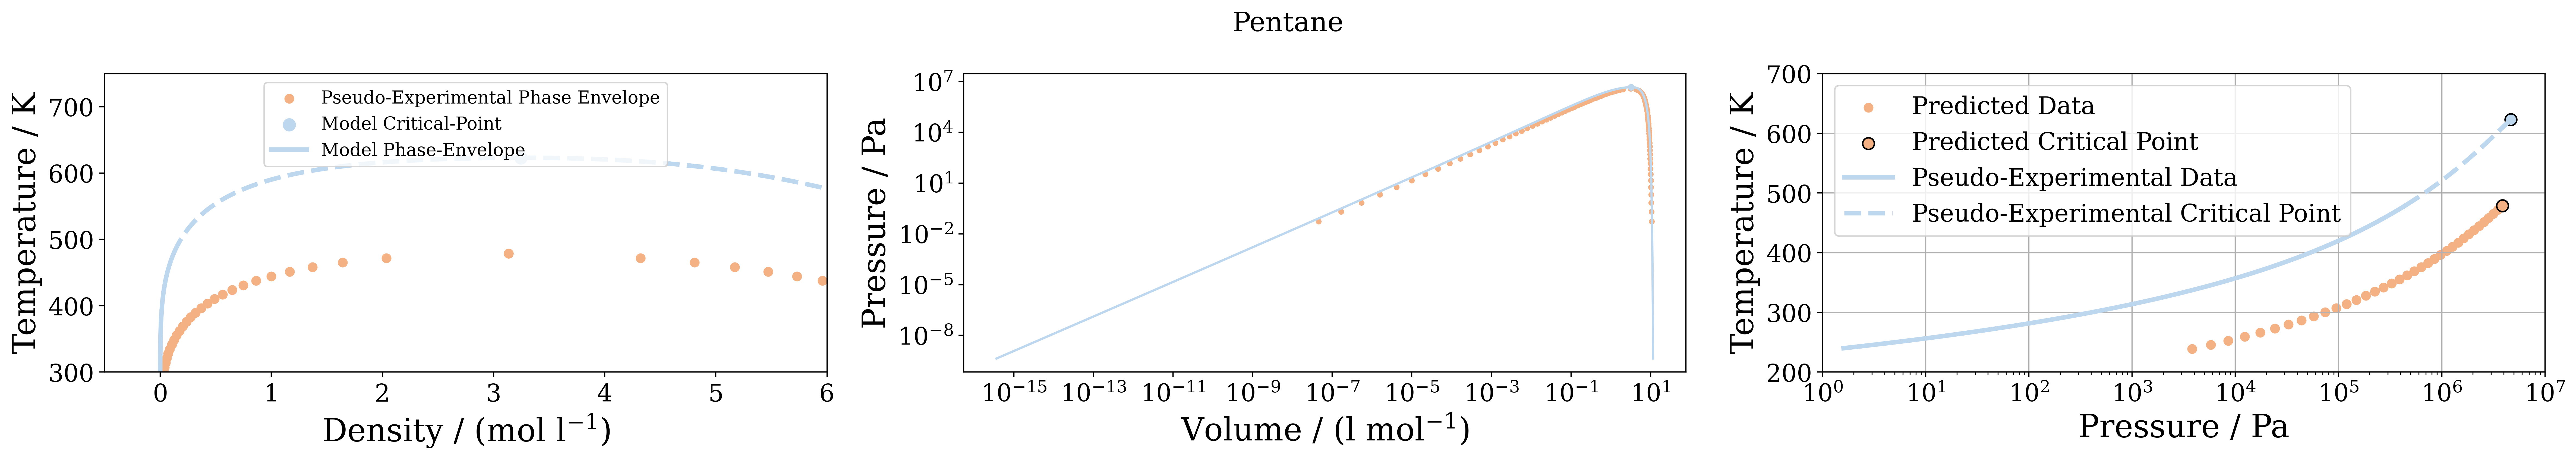

In [42]:
# Plot source pcp saft and saft-vr mie regressed parameter phase envelope (over given temperature range)

test_species = "Pentane"
# test_species = "2,2,4,4,6,8,8-heptamethylnonane"

# set plotting properties
plot_all_exptl_data = true
second_deriv_props_p = 10^5
n_points_exptl = 50
same_temp_range = false
plot_dashed_above_crit = true
epoch = 1# length(processed_data[1,:m])
label_fontsize = 21
ticks_fontsize = 16
T_min_plot = 240

source_data_test_species = filter(row -> row.common_name == lowercase(test_species), pcp_source_params);
processed_data_split = processed_data #filter(row -> row.split == "val", processed_data)

# obtain plotting data
T_range_pcp, pcp_crits, v_liq_range_pcp, v_vap_range_pcp, p_range_pcp, cp_range_pcp = sat_props_calc_PCP(species=lowercase(test_species), source_data_test_species=source_data_test_species, plot_all_exptl_data=plot_all_exptl_data, second_deriv_props_p=second_deriv_props_p,n_points=n_points_exptl, same_temp_range=same_temp_range)
T_range_vrmie, vrmie_crits, v_liq_range_vrmie, v_vap_range_vrmie, p_range_vrmie, cp_range_vrmie = sat_props_calc_VrMie(species=lowercase(test_species), pcp_source_params_split=source_data_test_species, processed_data_split=processed_data_split, plot_all_exptl_data=plot_all_exptl_data, epoch=epoch, second_deriv_props_p=second_deriv_props_p, same_temp_range=same_temp_range)

v_liq_range_pcp, v_liq_range_vrmie = remove_nans(v_liq_range_pcp, v_liq_range_vrmie)
v_vap_range_pcp, v_vap_range_vrmie = remove_nans(v_vap_range_pcp, v_vap_range_vrmie)
p_range_pcp, p_range_vrmie = remove_nans(p_range_pcp, p_range_vrmie)
cp_range_pcp, cp_range_vrmie = remove_nans(cp_range_pcp, cp_range_vrmie)

if plot_all_exptl_data == true
    pcp_v_plot = vcat(v_liq_range_pcp, pcp_crits[3], v_vap_range_pcp)
    pcp_rho_plot = 1e-3 ./pcp_v_plot
    pcp_T_plot_envelope = vcat(T_range_pcp, pcp_crits[1], T_range_pcp)
    pcp_P_plot_envelope = vcat(p_range_pcp, pcp_crits[2], p_range_pcp)
    pcp_T_plot_cc = vcat(T_range_pcp, pcp_crits[1])
    pcp_P_plot_cc = vcat(p_range_pcp, pcp_crits[2])
else
    pcp_v_plot = vcat(v_liq_range_pcp, v_vap_range_pcp)
    pcp_rho_plot = 1e-3 ./pcp_v_plot
    pcp_T_plot_envelope = vcat(T_range_pcp, T_range_pcp)
    pcp_P_plot_envelope = vcat(p_range_pcp, p_range_pcp)
    pcp_T_plot_cc = T_range_pcp
    pcp_P_plot_cc = p_range_pcp
end

vrmie_rho_plot = 1e-3 ./vcat(v_liq_range_vrmie, vrmie_crits[3], reverse(v_vap_range_vrmie))
vrmie_T_plot = vcat(T_range_vrmie, vrmie_crits[1], reverse(T_range_vrmie))
vrmie_P_plot = vcat(p_range_vrmie, vrmie_crits[2], reverse(p_range_vrmie))
vrmie_rho_plot_liq = 1e-3 ./vcat(v_liq_range_vrmie, vrmie_crits[3])
vrmie_rho_plot_vap = 1e-3 ./v_vap_range_vrmie

index_cutoff_crit = argmin(abs.(T_range_vrmie .- pcp_crits[1]))
index_cutoff_T_min_vrmie = argmin(abs.(T_range_vrmie .- T_min_plot))
index_cutoff_T_min_pcp = argmin(abs.(pcp_T_plot_cc .- T_min_plot))

figure_1, axes_1 = plt.subplots(1,3, figsize=(24, 6), dpi=400)
figure_1.suptitle(test_species, fontsize=18,y=0.95)

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif",size=ticks_fontsize)

# Axes 1
axes_1[1].scatter(pcp_rho_plot, pcp_T_plot_envelope, color="#F4B183",s=30)
axes_1[1].scatter(1e-3/vrmie_crits[3], vrmie_crits[1], color="#BDD7EE",s=60)

if plot_dashed_above_crit == true
    
    index_cutoff_crit = argmin(abs.(T_range_vrmie .- pcp_crits[1]))
    
    axes_1[1].plot(vrmie_rho_plot_liq[1:index_cutoff_crit-1], vcat(T_range_vrmie, vrmie_crits[1])[1:index_cutoff_crit-1],color="#BDD7EE",linewidth=3)
    axes_1[1].plot(vrmie_rho_plot_liq[index_cutoff_crit:end], vcat(T_range_vrmie, vrmie_crits[1])[index_cutoff_crit:end],color="#BDD7EE","--",linewidth=3)

    axes_1[1].plot(vrmie_rho_plot_vap[1:index_cutoff_crit-1], T_range_vrmie[1:index_cutoff_crit-1],color="#BDD7EE",linewidth=3)
    axes_1[1].plot(vrmie_rho_plot_vap[index_cutoff_crit:end], T_range_vrmie[index_cutoff_crit:end],color="#BDD7EE","--",linewidth=3)

else

    axes_1[1].plot(vrmie_rho_plot, vrmie_T_plot,color="#BDD7EE",linewidth=2)

end

axes_1[2].scatter(pcp_rho_plot, pcp_P_plot_envelope, color="#F4B183",s=8)
axes_1[2].scatter(1e-3 /vrmie_crits[3], vrmie_crits[2], color="#BDD7EE",s=12)
axes_1[2].loglog(vrmie_rho_plot, vrmie_P_plot ,color="#BDD7EE")

# axes_1[3].axhline(0.95*pcp_crits[1], color="black", linestyle="--", label="Horizontal Line",linewidth=3)
axes_1[3].scatter(pcp_P_plot_cc[index_cutoff_T_min_pcp:end], pcp_T_plot_cc[index_cutoff_T_min_pcp:end], color="#F4B183",s=30)
axes_1[3].scatter(pcp_crits[2], pcp_crits[1], color="#F4B183",s=60,edgecolors="black")

axes_1[3].plot(p_range_vrmie[index_cutoff_T_min_vrmie:index_cutoff_crit-1], T_range_vrmie[index_cutoff_T_min_vrmie:index_cutoff_crit-1], color="#BDD7EE",linewidth=3)
axes_1[3].plot(p_range_vrmie[index_cutoff_crit:end], T_range_vrmie[index_cutoff_crit:end], color="#BDD7EE",linewidth=3,"--")
axes_1[3].scatter(vrmie_crits[2], vrmie_crits[1], color="#BDD7EE",s=60,edgecolors="black")

# swap colours, styles etc. for PCP/VR Mie
# axes_1[3].plot(pcp_P_plot_cc[index_cutoff_T_min_pcp:end], pcp_T_plot_cc[index_cutoff_T_min_pcp:end], color="#F4B183",linewidth=3)
# axes_1[3].scatter(pcp_crits[2], pcp_crits[1], color="#F4B183",s=60,edgecolors="black")

# axes_1[3].scatter(p_range_vrmie[index_cutoff_T_min_vrmie:40:end], T_range_vrmie[index_cutoff_T_min_vrmie:40:end], color="#BDD7EE",s=30)
# axes_1[3].scatter(vrmie_crits[2], vrmie_crits[1], color="#BDD7EE",s=60,edgecolors="black")


# axes_1[1].set_xticks([10^-3, 10^-2, 10^-1, 10^0, 10^1, 10^2],ticks_fontsize = 14)
# axes_1[1].set_yticks(range(150,400,6))
axes_1[1].set_ylim([300,750])
axes_1[1].set_xlim([-0.5,6])
axes_1[1].set_xlabel(L"Density / (mol l$\mathregular{^{-1}}$)",fontsize=label_fontsize)
axes_1[1].set_ylabel("Temperature / K",fontsize=label_fontsize)
axes_1[1].legend(["Pseudo-Experimental Phase Envelope","Model Critical-Point","Model Phase-Envelope"],fontsize=11.75,loc="upper center")
# axes_1[1].legend(["Pseudo-Experimental Data","Model Data"],fontsize=11.75,loc="upper center")

# axes_1[1].set_xticks([10^-3, 10^-2, 10^-1, 10^0, 10^1, 10^2])
# axes_1[1].set_yticks(range(150,400,6))
# axes_1[2].set_ylim([10^-10,10^12])
# axes_1[1].set_xlim([10^-3,10^2])
axes_1[2].set_xlabel(L"Volume / (l mol$\mathregular{^{-1}}$)",fontsize=label_fontsize)
axes_1[2].set_ylabel("Pressure / Pa",fontsize=label_fontsize)
# axes_1[2].legend(["Pseudo-Experimental Data","Predicted Critical Point","Predicted Point"],loc="upper left")


axes_1[3].set_xscale("log")
# axes_1[2].set_xtickslabel(e)
axes_1[3].set_xticks([10^0, 10^1, 10^2, 10^3, 10^4, 10^5, 10^6, 10^7])
axes_1[3].set_xlim([10^0,10^7])
axes_1[3].set_ylim([200,700])
axes_1[3].set_ylabel("Temperature / K",fontsize=label_fontsize)
axes_1[3].set_xlabel("Pressure / Pa",fontsize=label_fontsize)
axes_1[3].grid("on")
axes_1[3].legend(["Predicted Data","Predicted Critical Point","Pseudo-Experimental Data","Pseudo-Experimental Critical Point",],fontsize=ticks_fontsize)
# axes_1[3].legend(["0.95 Predicted Critical Temperature"],fontsize=ticks_fontsize, loc="upper left")


tight_layout()

In [5]:
root_folder = "24_long_scripts"
runs_main_dir = readdir("../jobs/$root_folder/")
target_fold_directories = filter(dir -> contains(dir, "13_"), runs_main_dir)

println(target_fold_directories)

files_for_val_training = []
files_for_val_error = []

for i in target_fold_directories

    push!(files_for_val_training, "../jobs/$root_folder/$i/params_log.csv")

    error_log_files = filter(dir -> contains(dir, ".o"), readdir("../jobs/$root_folder/$i"))
    push!(files_for_val_error, "../jobs/$root_folder/$i/$(error_log_files[end])")

end

println(length(files_for_val_training))
println(length(files_for_val_error))

["13_clip_points_rho_1024_strat1", "13_clip_points_rho_1024_strat2", "13_clip_points_rho_1024_strat3", "13_clip_points_rho_1024_strat4", "13_clip_points_rho_1024_strat5"]
5
5


In [6]:
files_to_average = [1,2,3,4,5]
line_start_main_training = 60

epochs_min_val_loss, total_epochs, average_val_loss, average_train_loss, average_epoch_time = readout_file_analysis(files_for_val_error=files_for_val_error, line_start_main_training=line_start_main_training,files_to_average=files_to_average)

@show epochs_min_val_loss
@show total_epochs;
# @show average_val_loss

[2685, 2197, 3176, 2006, 2599]
epochs_min_val_loss = 66
total_epochs = [2685, 2197, 3176, 2006, 2599]


2005
0.03245902576732831
0.5218520149170918


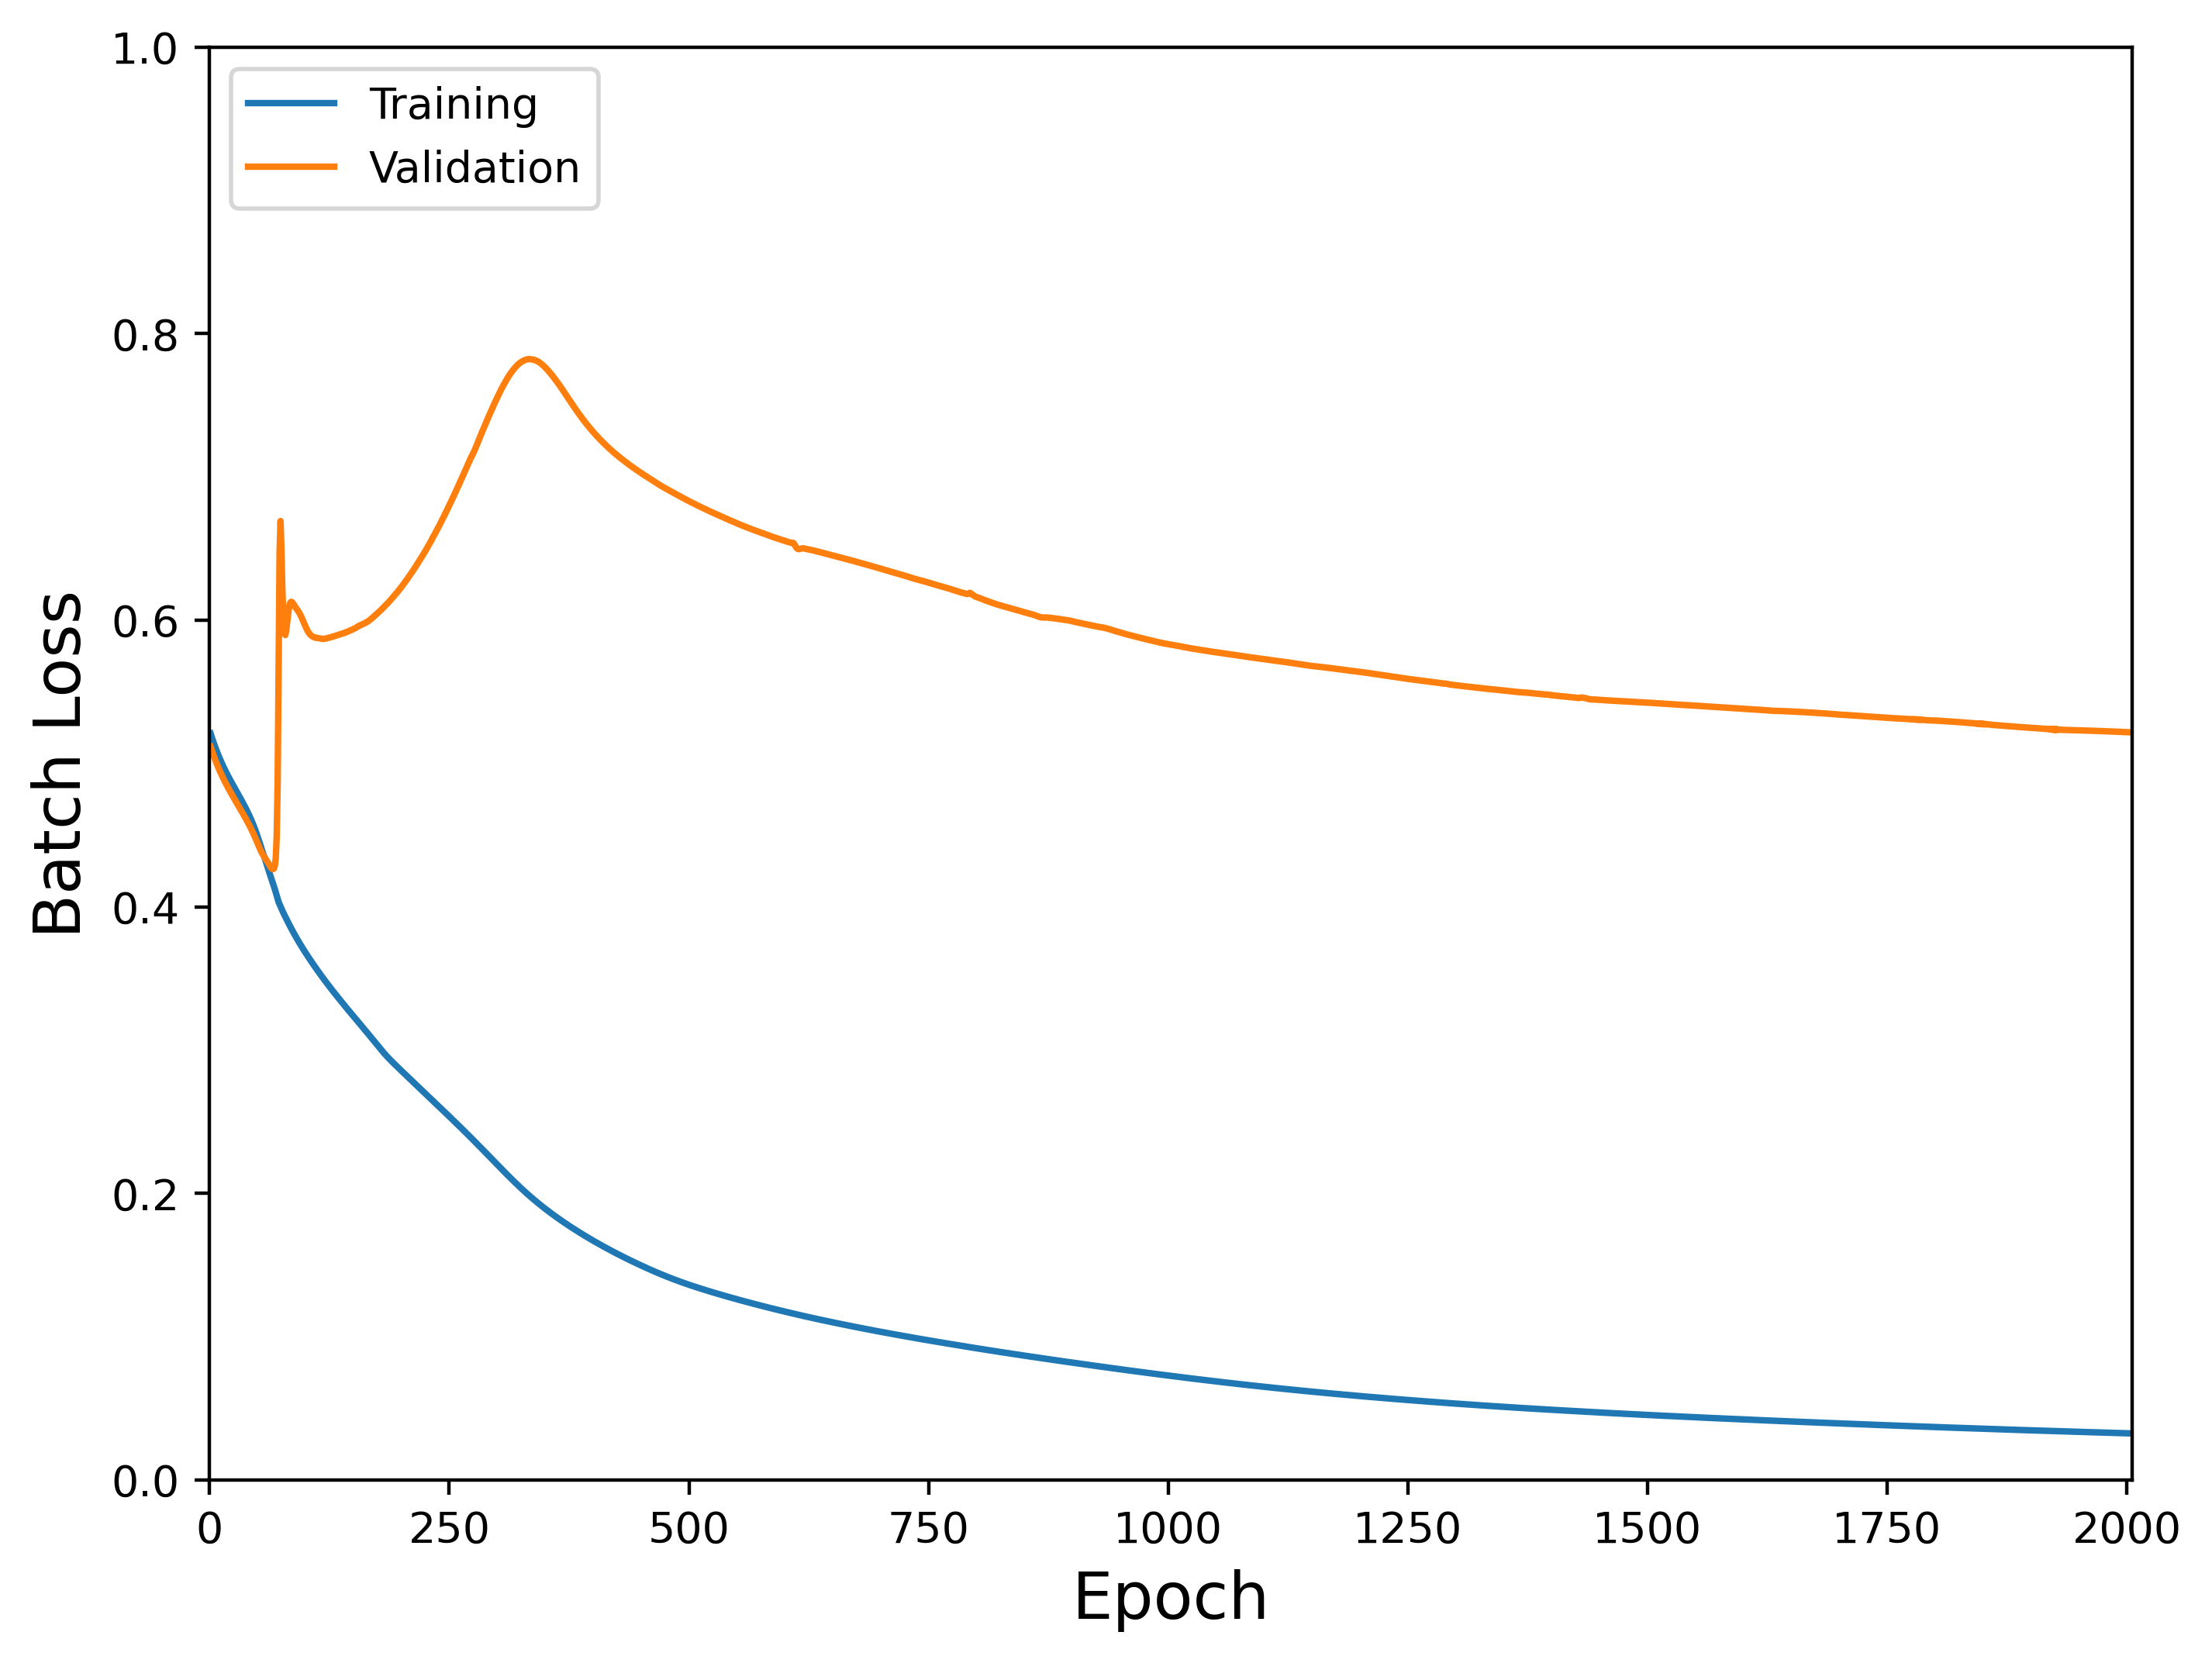

In [7]:
fig2, axes2 = plt.subplots(1, 1, figsize=(8, 6), dpi=400)

value_ignored = 60 # use this to set the epoch range for plot

axes2.plot(1:minimum(total_epochs[(total_epochs .!= value_ignored)]), average_train_loss)
axes2.plot(1:minimum(total_epochs[(total_epochs .!= value_ignored)]), average_val_loss)

axes2.set_xlabel("Epoch", fontsize=15)
axes2.set_ylabel("Batch Loss", fontsize=15)
axes2.set_xlim([0,minimum(total_epochs[(total_epochs .!= value_ignored)])])
axes2.legend(["Training","Validation"],loc="upper left")
axes2.set_ylim([0,1])

epoch_min_late = argmin(abs.(average_val_loss[100:end] .- minimum(average_val_loss[100:end])))
println(epoch_min_late + 99)

println(average_train_loss[2006])
println(average_val_loss[2006])

In [8]:
files_for_val_training_trimmed = [files_for_val_training[i] for i in files_to_average]

string_arrays_dict = Dict{Int, Vector{String}}()
processed_data_storage = []

keys_string_dict = 1:length(files_for_val_training_trimmed)

for (key, path) in zip(keys_string_dict,files_for_val_training_trimmed)
        
        processed_data = process_raw_params(path, pcp_source_params)

        processed_data_split = filter(row -> row.split == "val", processed_data)

        push!(processed_data_storage, processed_data_split)

        string_arrays_dict[key] = processed_data_split.species

end

┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578
┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578
┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578
┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578
┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ 

In [9]:
analyse_training = false

epoch = 2005 # minimum(total_epochs) #(shortest of all five folds), true (max length each fold)
n_points = 50

# Specify the range of experimental data to be plotted
plot_all_exptl_data = false
same_temp_range = true
remove_methane = true

# Computed data properties
second_deriv_props_p = 10^5

species_lists = collect(processed_data_storage[i][!,:species] for i = 1:length(files_to_average))
species_lists_concat = (vcat(species_lists...))

if remove_methane == true
    species_lists_concat = [x for x in species_lists_concat if x != "methane"]
    species_lists = [[x for x in species_lists[i] if x != "methane"] for i = 1:length(files_to_average)]
    length_frames = length.(species_lists)
end

num_rows = length(species_lists_concat)

val_data_summary_APD = DataFrame(
    common_name = fill("", num_rows),
    isomeric_SMILES = fill("", num_rows),
    Mw = fill(0.0, num_rows),
    APD_vsat_l = fill(0.0, num_rows),
    APD_vsat_v = fill(0.0, num_rows),
    APD_rhosat_l = fill(0.0, num_rows),
    APD_rhosat_v = fill(0.0, num_rows),
    APD_psat = fill(0.0, num_rows),
    APD_cp = fill(0.0, num_rows),
    APD_cv = fill(0.0, num_rows),
    APD_speed_sound = fill(0.0, num_rows),
) ;

val_data_summary_AAD = DataFrame(
    common_name = fill("", num_rows),
    isomeric_SMILES = fill("", num_rows),
    Mw = fill(0.0, num_rows),
    AAD_vsat_l = fill(0.0, num_rows),
    AAD_vsat_v = fill(0.0, num_rows),
    AAD_rhosat_l = fill(0.0, num_rows),
    AAD_rhosat_v = fill(0.0, num_rows),
    AAD_psat = fill(0.0, num_rows),
    AAD_cp = fill(0.0, num_rows),
    AAD_cv = fill(0.0, num_rows),
    AAD_speed_sound = fill(0.0, num_rows),
) ;

row_counter_data_gen = 1
frame_counter = 1

for i = 1:length(species_lists_concat)

    println(species_lists_concat[i])

    if analyse_training == true

        if remove_methane == true

            while i <= sum(length_frames[1:frame_counter])

                processed_data_split = processed_data_storage[frame_counter]

                if i == sum(length_frames[1:frame_counter])
                    frame_counter += 1
                end
                
                break
            end

        else
            processed_data_split = processed_data_storage[Int(floor((i-1)/64) + 1)]
        end

    else

    # find species i data
    key_i = find_key(string_arrays_dict, lowercase(species_lists_concat[i]))
    processed_data_split = processed_data_storage[key_i]

    end

    if epoch == true
        epoch = length(processed_data_storage[key_i][!,:m][1])
    end

    source_data_test_species = filter(row -> row.common_name == lowercase(species_lists_concat[i]), pcp_source_params);

    T_range_pcp, pcp_crits, v_liq_range_pcp, v_vap_range_pcp, p_range_pcp, cp_range_pcp, cv_range_pcp, speed_sound_range_pcp = sat_props_calc_PCP(species=lowercase(species_lists_concat[i]), source_data_test_species=source_data_test_species, plot_all_exptl_data=plot_all_exptl_data, second_deriv_props_p=second_deriv_props_p,n_points=n_points, same_temp_range=same_temp_range)
    T_range_vrmie, vrmie_crits, v_liq_range_vrmie, v_vap_range_vrmie, p_range_vrmie, cp_range_vrmie, cv_range_vrmie, speed_sound_range_vrmie = sat_props_calc_VrMie(species=lowercase(species_lists_concat[i]), pcp_source_params_split=source_data_test_species, processed_data_split=processed_data_split, plot_all_exptl_data=plot_all_exptl_data, n_points=n_points, epoch=epoch, second_deriv_props_p=second_deriv_props_p, same_temp_range=same_temp_range)

    v_liq_range_pcp, v_liq_range_vrmie = remove_nans(v_liq_range_pcp, v_liq_range_vrmie)
    v_vap_range_pcp, v_vap_range_vrmie = remove_nans(v_vap_range_pcp, v_vap_range_vrmie)
    p_range_pcp, p_range_vrmie = remove_nans(p_range_pcp, p_range_vrmie)
    cp_range_pcp, cp_range_vrmie = remove_nans(cp_range_pcp, cp_range_vrmie)
    cv_range_pcp, cv_range_vrmie = remove_nans(cv_range_pcp, cv_range_vrmie)
    speed_sound_range_pcp, speed_sound_range_vrmie = remove_nans(speed_sound_range_pcp, speed_sound_range_vrmie)

    rho_liq_range_pcp = 1 ./v_liq_range_pcp
    rho_liq_range_vrmie = 1 ./v_liq_range_vrmie

    rho_vap_range_pcp = 1 ./v_vap_range_pcp
    rho_vap_range_vrmie = 1 ./v_vap_range_vrmie

    if length(v_liq_range_vrmie) > 0
        
    v_sat_l_APD = average_percentage_deviation(v_liq_range_vrmie, v_liq_range_pcp)
    v_sat_v_APD = average_percentage_deviation(v_vap_range_vrmie, v_vap_range_pcp)
    rho_sat_l_APD = average_percentage_deviation(rho_liq_range_vrmie, rho_liq_range_pcp)
    rho_sat_v_APD = average_percentage_deviation(rho_vap_range_vrmie, rho_vap_range_pcp)
    p_sat_APD = average_percentage_deviation(p_range_vrmie, p_range_pcp)
    cp_sat_APD = average_percentage_deviation(cp_range_vrmie, cp_range_pcp)
    cv_sat_APD = average_percentage_deviation(cv_range_vrmie, cv_range_pcp)
    speed_sound_APD = average_percentage_deviation(speed_sound_range_vrmie, speed_sound_range_pcp)

    v_sat_l_AAD = average_absolute_deviation(v_liq_range_vrmie, v_liq_range_pcp)
    v_sat_v_AAD = average_absolute_deviation(v_vap_range_vrmie, v_vap_range_pcp)
    rho_sat_l_AAD = average_absolute_deviation(rho_liq_range_vrmie, rho_liq_range_pcp)
    rho_sat_v_AAD = average_absolute_deviation(rho_vap_range_vrmie, rho_vap_range_pcp)
    p_sat_AAD = average_absolute_deviation(p_range_vrmie, p_range_pcp)
    cp_sat_AAD = average_absolute_deviation(cp_range_vrmie, cp_range_pcp)
    cv_sat_AAD = average_absolute_deviation(cv_range_vrmie, cv_range_pcp)
    speed_sound_AAD = average_absolute_deviation(speed_sound_range_vrmie, speed_sound_range_pcp)

    processed_data_test_species = filter(row -> row.species == lowercase(species_lists_concat[i]), processed_data_split);

    val_data_summary_APD[row_counter_data_gen,:common_name] = processed_data_test_species.species[1]
    val_data_summary_APD[row_counter_data_gen,:isomeric_SMILES] = processed_data_test_species.isomeric_SMILES[1]
    val_data_summary_APD[row_counter_data_gen,:Mw] = processed_data_test_species.Mw[1]
    val_data_summary_APD[row_counter_data_gen,:APD_vsat_l] = v_sat_l_APD
    val_data_summary_APD[row_counter_data_gen,:APD_vsat_v] = v_sat_v_APD
    val_data_summary_APD[row_counter_data_gen,:APD_rhosat_l] = rho_sat_l_APD
    val_data_summary_APD[row_counter_data_gen,:APD_rhosat_v] = rho_sat_v_APD
    val_data_summary_APD[row_counter_data_gen,:APD_psat] = p_sat_APD
    val_data_summary_APD[row_counter_data_gen,:APD_cp] = cp_sat_APD
    val_data_summary_APD[row_counter_data_gen,:APD_cv] = cv_sat_APD
    val_data_summary_APD[row_counter_data_gen,:APD_speed_sound] = speed_sound_APD

    val_data_summary_AAD[row_counter_data_gen,:common_name] = processed_data_test_species.species[1]
    val_data_summary_AAD[row_counter_data_gen,:isomeric_SMILES] = processed_data_test_species.isomeric_SMILES[1]
    val_data_summary_AAD[row_counter_data_gen,:Mw] = processed_data_test_species.Mw[1]
    val_data_summary_AAD[row_counter_data_gen,:AAD_vsat_l] = v_sat_l_AAD
    val_data_summary_AAD[row_counter_data_gen,:AAD_vsat_v] = v_sat_v_AAD
    val_data_summary_AAD[row_counter_data_gen,:AAD_rhosat_l] = rho_sat_l_AAD
    val_data_summary_AAD[row_counter_data_gen,:AAD_rhosat_v] = rho_sat_v_AAD
    val_data_summary_AAD[row_counter_data_gen,:AAD_psat] = p_sat_AAD
    val_data_summary_AAD[row_counter_data_gen,:AAD_cp] = cp_sat_AAD
    val_data_summary_AAD[row_counter_data_gen,:AAD_cv] = cv_sat_AAD
    val_data_summary_AAD[row_counter_data_gen,:AAD_speed_sound] = speed_sound_AAD

    end

    row_counter_data_gen += 1
            
end

println("Mean AAD over validation sets:")
println("Satv. l.: $(mean(val_data_summary_AAD.AAD_vsat_l)), Satv. v.: $(round(mean(val_data_summary_AAD.AAD_vsat_v),digits=2)), Satrho. l.: $(mean(val_data_summary_AAD.AAD_rhosat_l)), Satrho. v.: $(round(mean(val_data_summary_AAD.AAD_rhosat_v),digits=2)), Satp: $(round(mean(val_data_summary_AAD.AAD_psat),digits=2)), Cp1bar: $(round(mean(val_data_summary_AAD.AAD_cp),digits=2))")
println("Mean APD over validation sets:")
println("Satv. l.: $(round(mean(val_data_summary_APD.APD_vsat_l),digits=2)), Satv. v.: $(round(mean(val_data_summary_APD.APD_vsat_v),digits=2)), Satrho. l.: $(round(mean(val_data_summary_APD.APD_rhosat_l),digits=2)), Satrho. v.: $(round(mean(val_data_summary_APD.APD_rhosat_v),digits=2)), Satp: $(round(mean(val_data_summary_APD.APD_psat),digits=2)), Cp1bar: $(round(mean(val_data_summary_APD.APD_cp),digits=2))")
println(target_fold_directories)

2-methylbutane
2-methylpentane
2,2,3-trimethylbutane
heptane
3,4-dimethylhexane
3-methyl-3-ethylpentane
2,2,4-trimethylpentane
2,4,4-trimethylhexane
2,3,3,4-tetramethylpentane
decane
2-methyldecane
dodecane
3-methyltridecane
hexadecane
eicosane
ethane
2,2-dimethylpropane
2,2-dimethylbutane
2,3-dimethylpentane
2,4-dimethylpentane
3-methylheptane
2-methyl-3-ethyl-pentane
2,4-dimethylhexane
2,2,3,4-tetramethylpentane
2,2,5-trimethylhexane
2,6-dimethyloctane
2,3-dimethylnonane
3-methyldodecane
2,3-dimethyldodecane
2,2,4,4,6,8,8-heptamethylnonane
tetracosane
propane
pentane
2,3-dimethylbutane
3-methylhexane
2,5-dimethylhexane
2,2,3-trimethylpentane
2,3,3-trimethylpentane
4-methylheptane
3,3-diethylpentane
2,3-dimethylheptane
2,7-dimethyloctane
3-methylundecane
tridecane
tetradecane
heptadecane
heptacosane
n-butane
3-methylpentane
3-ethylpentane
3,3-dimethylpentane
2-methylheptane
octane
3-ethylhexane
2,3-dimethylhexane
2-methyloctane
2,2,3,3-tetramethylpentane
3-methyldecane
2,3-dimethyldec

In [ ]:
1: ./10^3

3: ./10^5

In [111]:
println("APD Sat. Liq. Density: $(mean(filter(x -> x != 0.0, val_data_summary_APD.APD_rhosat_l)))")
println("APD Sat. Vap. Density: $(mean(filter(x -> x != 0.0, val_data_summary_APD.APD_rhosat_v)))")
println("APD Sat. P: $(mean(filter(x -> x != 0.0, val_data_summary_APD.APD_psat)))")
println("APD Isobaric Heat Capacity: $(mean(filter(x -> x != 0.0, val_data_summary_APD.APD_cp)))")

APD Sat. Liq. Density: 7.961930178655619
APD Sat. Vap. Density: 80.95096495636624
APD Sat. P: 80.11954765074272
APD Isobaric Heat Capacity: 31.580734679703195


In [112]:
println("APD Sat. Liq. Density: $(mean(val_data_summary_APD.APD_rhosat_l))")
println("APD Sat. Vap. Density: $(mean(val_data_summary_APD.APD_rhosat_v))")
println("APD Sat. P: $(mean(val_data_summary_APD.APD_psat))")
println("APD Isobaric Heat Capacity: $(mean(val_data_summary_APD.APD_cp))")

# println(median(val_data_summary_AAD.APD_rhosat_l))

APD Sat. Liq. Density: 7.961930178655619
APD Sat. Vap. Density: 80.95096495636624
APD Sat. P: 80.11954765074272
APD Isobaric Heat Capacity: 31.580734679703195


In [153]:
println(sort(val_data_summary_APD,:Mw))

79×11 DataFrame
 Row │ common_name                      isomeric_SMILES                    Mw       APD_vsat_l  APD_vsat_v     APD_rhosat_l  APD_rhosat_v  APD_psat   APD_cp    APD_cv    APD_speed_sound 
     │ String                           String                             Float64  Float64     Float64        Float64       Float64       Float64    Float64   Float64   Float64         
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ ethane                           CC                                  30.047   17.1923       76.0551        21.1988        68.7656    57.2117   31.4609   117.203           94.2348
   2 │ propane                          CCC                                 44.063    5.59928       3.32988e5      5.44111       52.2394    51.4217   40.9416   145.692           92.5806
   3 │ n-butane                         CCCC       

Pentane
3-ethylhexane
Nonane
2,3-dimethylnonane
2,2,4,4,6,8,8-Heptamethylnonane
hexadecane


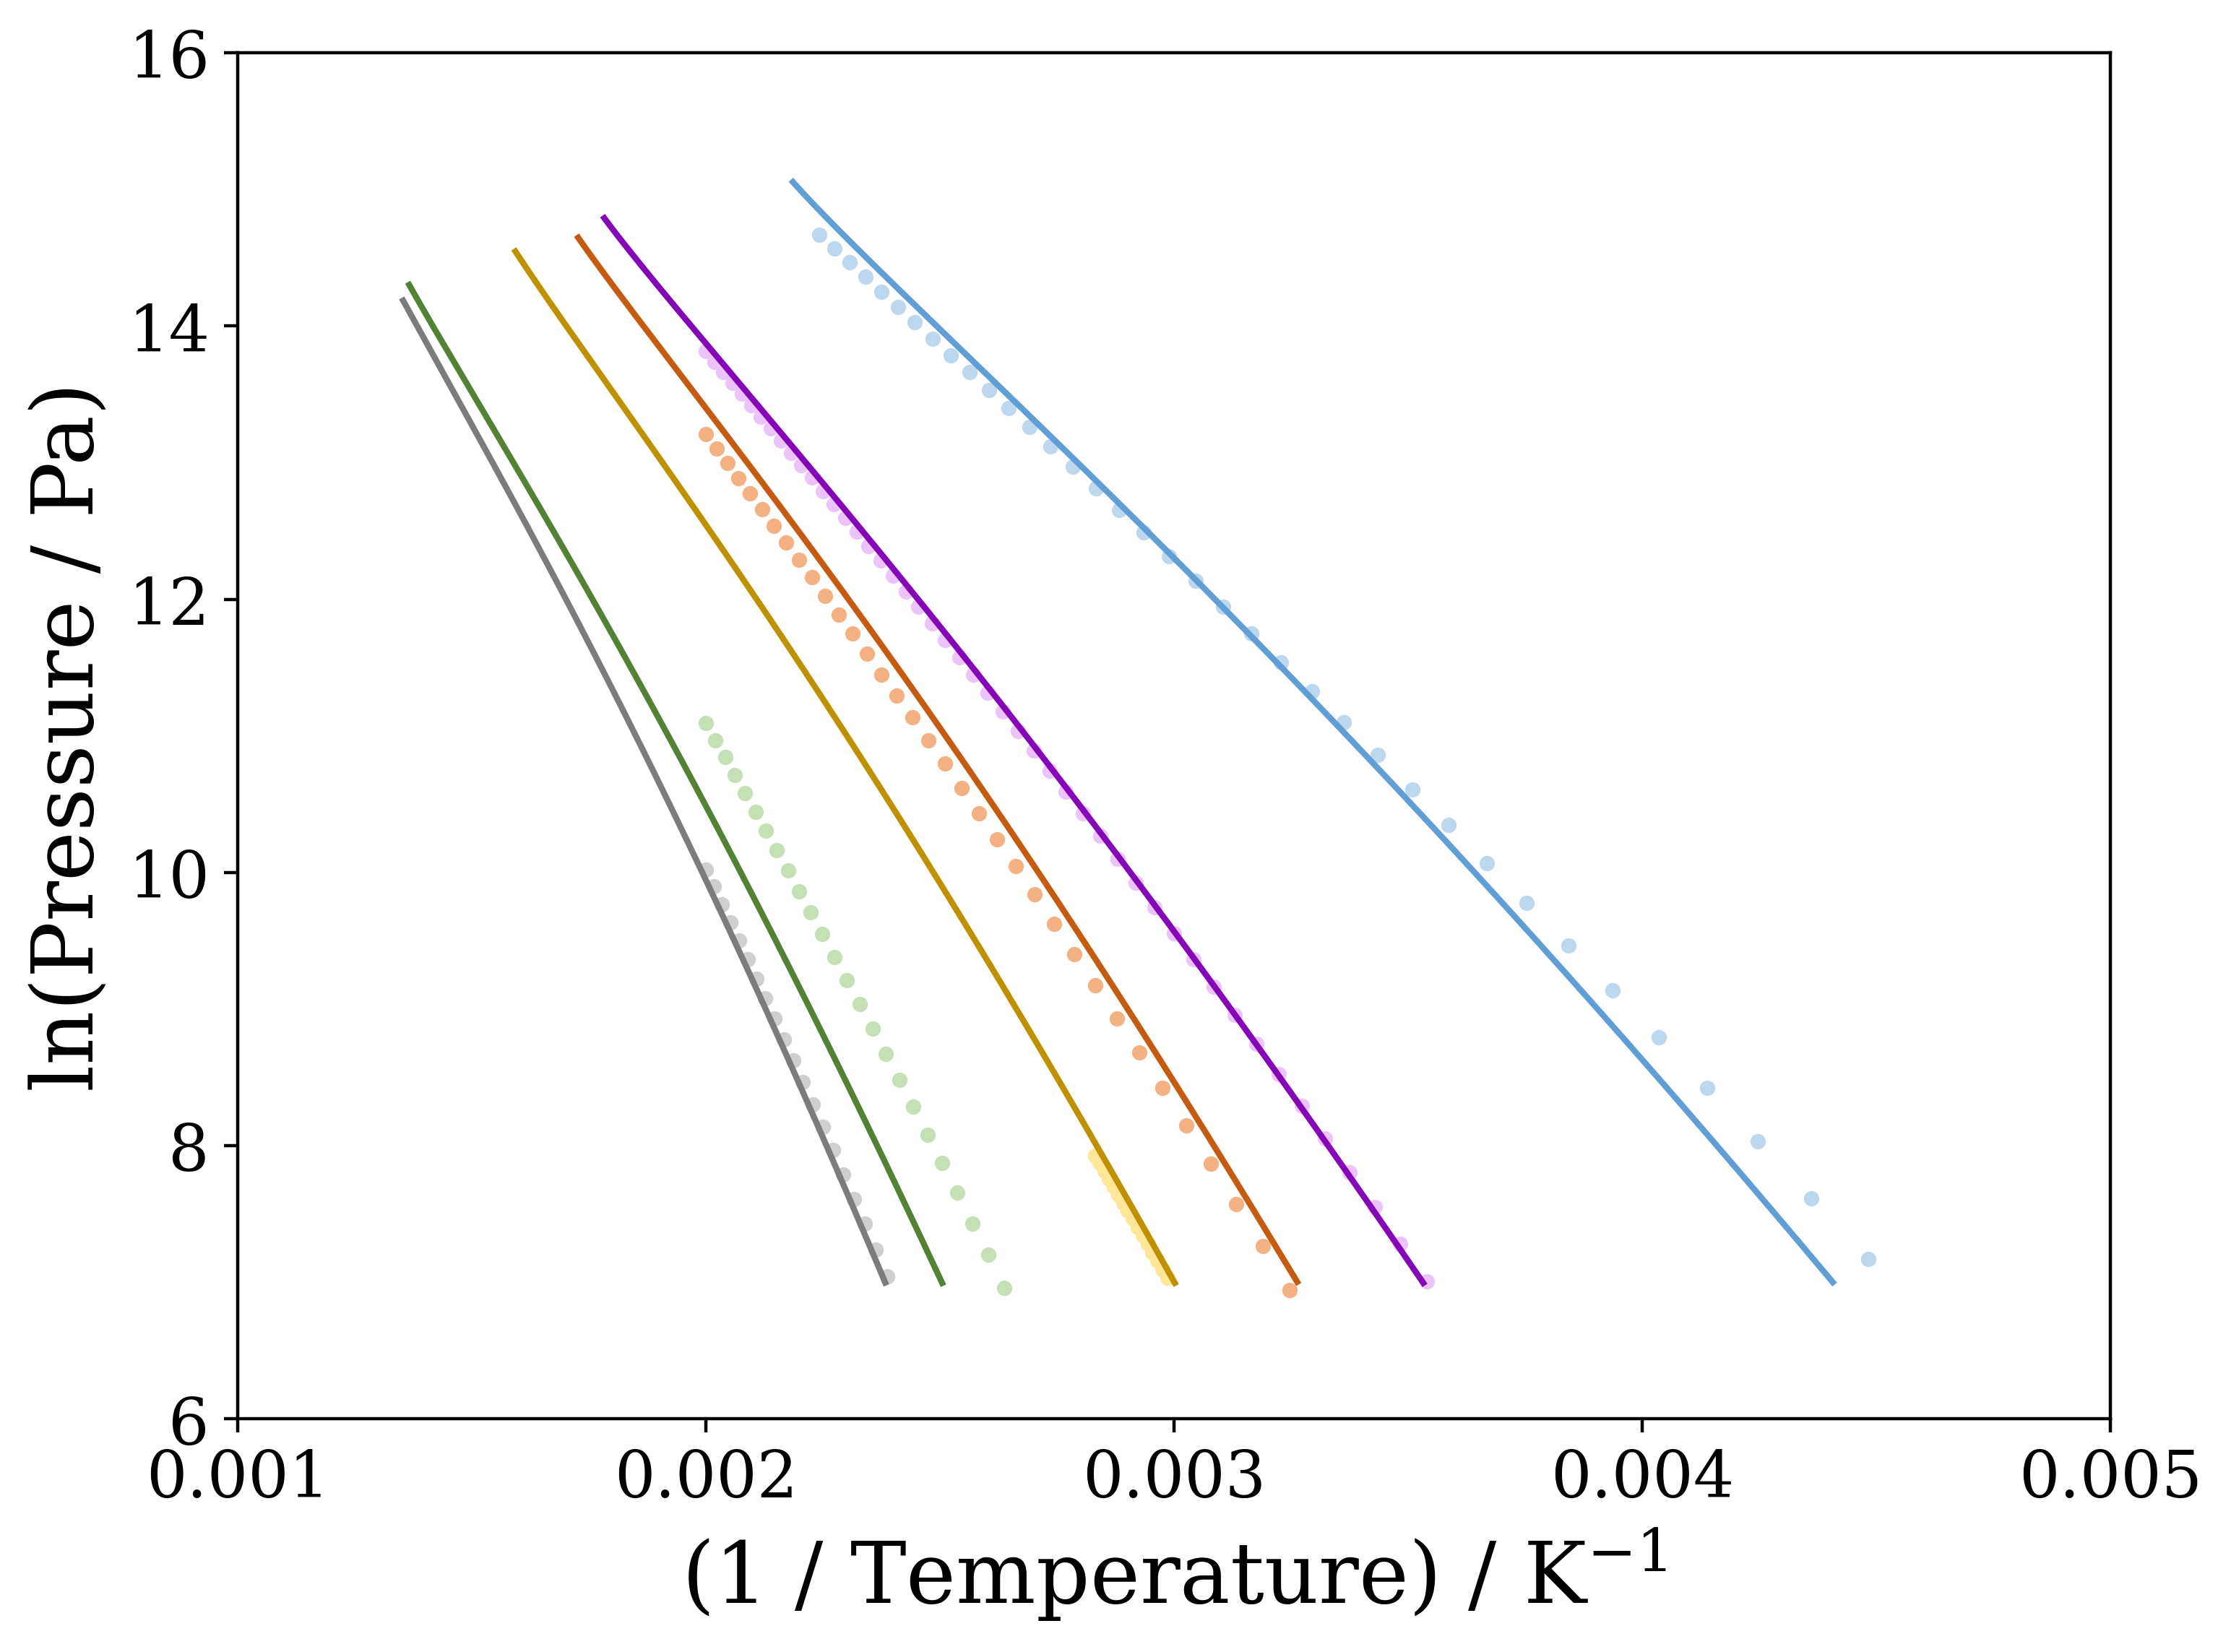

In [13]:
# Plot saturation data for validation set for these species
species = ["Pentane","3-ethylhexane","Nonane","2,3-dimethylnonane","2,2,4,4,6,8,8-Heptamethylnonane", "hexadecane"]

fontsize_label_title = 21
fontsize_ticks = 16

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif", size=fontsize_ticks)

# Specify the range and spacing of experimental data to be plotted
plot_all_exptl_data = false
n_points_exptl = 50
same_temp_range = false

# Computed data properties
second_deriv_props_p = 10^5

# Specify vrmie epoch to plot
epoch = 2005 #length(processed_data_storage[1][!,:m][1])

# Plot line colours
colours_exp = ["#BDD7EE","#ECC3FD","#F4B183","#FFE699","#C5E0B4","#D0CECE"] # Experimental, Predicted
colours_pred = ["#609ED6","#8406B6","#C55A11","#BF9000","#548235","#7C7C7C"] # Experimental, Predicted

plt.figure(figsize=(8, 6), dpi=400)
# figure1.suptitle("Temperature-Density Phase Envelopes", fontsize=24,y=0.95)

for i = 1:length(species)

    # find species i data for validation
    key_i = find_key(string_arrays_dict, lowercase(species[i]))
    processed_data_split = processed_data_storage[key_i]

    # specify species i data fold for training
    # keys = [4,5,4,2,2,3]
    # processed_data_split = processed_data_storage[keys[i]]

    source_data_test_species = filter(row -> row.common_name == lowercase(species[i]), pcp_source_params);

    T_range_pcp, pcp_crits, v_liq_range_pcp, v_vap_range_pcp, p_range_pcp, cp_range_pcp = sat_props_calc_PCP(species=lowercase(species[i]), source_data_test_species=source_data_test_species, plot_all_exptl_data=plot_all_exptl_data, second_deriv_props_p=second_deriv_props_p, same_temp_range=same_temp_range)
    T_range_vrmie, vrmie_crits, v_liq_range_vrmie, v_vap_range_vrmie, p_range_vrmie, cp_range_vrmie = sat_props_calc_VrMie(species=lowercase(species[i]), pcp_source_params_split=source_data_test_species, processed_data_split=processed_data_split, plot_all_exptl_data=plot_all_exptl_data, epoch=epoch, second_deriv_props_p=second_deriv_props_p, same_temp_range=same_temp_range)

    println(species[i])

    if plot_all_exptl_data == true
        pcp_v_plot = vcat(v_liq_range_pcp, pcp_crits[3], v_vap_range_pcp)
        pcp_rho_plot = 1e-3 ./pcp_v_plot
        pcp_T_plot_envelope = vcat(T_range_pcp, pcp_crits[1], T_range_pcp)
        pcp_P_plot_envelope = vcat(p_range_pcp, pcp_crits[2], p_range_pcp)
        pcp_T_plot_cc = vcat(T_range_pcp, pcp_crits[1])
        pcp_P_plot_cc = vcat(p_range_pcp, pcp_crits[2])
    else
        pcp_v_plot = vcat(v_liq_range_pcp, v_vap_range_pcp)
        pcp_rho_plot = 1e-3 ./pcp_v_plot
        pcp_T_plot_envelope = vcat(T_range_pcp, T_range_pcp)
        pcp_P_plot_envelope = vcat(p_range_pcp, p_range_pcp)
        pcp_T_plot_cc = T_range_pcp
        pcp_P_plot_cc = p_range_pcp
    end
    
    index_cutoff_pcp = argmin(abs.(log.(pcp_P_plot_cc) .- 7))
    index_cutoff_vrmie = argmin(abs.(log.(p_range_vrmie) .- 7))

    plt.scatter((1 ./pcp_T_plot_cc[index_cutoff_pcp:end]), log.(pcp_P_plot_cc[index_cutoff_pcp:end]),color=colours_exp[i],s=8)
    plt.plot((1 ./T_range_vrmie[index_cutoff_vrmie:end]), log.(p_range_vrmie[index_cutoff_vrmie:end]),color=colours_pred[i])

end

plt.ylim([6, 16])
plt.xlim([0.001, 0.005])
plt.xticks([0.001, 0.002, 0.003, 0.004, 0.005])
plt.set_xticklabels([])

plt.xlabel(L"(1 / Temperature) / K$\mathregular{^{-1}}$",fontsize=fontsize_label_title)
plt.ylabel("ln(Pressure / Pa)",fontsize=fontsize_label_title)


plt.tight_layout()


# Useful property setting
# axes_fig_1[k, j].set_xscale("log")
# axes_fig_1[k, j].set_xticks(xticks_pe[i])
# axes_fig_1[k, j].set_xlim([xticks_pe[i][1],xticks_pe[i][end]])
# axes_fig_1[k, j].set_yticks(yticks_pe[i])
# axes_fig_1[k, j].set_ylim([yticks_pe[i][1],yticks_pe[i][end]])


In [ ]:
# Plot saturation data for validation set for these species
species = ["Hexane","2-Methyl-3-Ethyl-Pentane","Nonadecane","2-Methylbutane","2,3-Dimethylundecane","2,2,3,4-Tetramethylpentane"]

fontsize_label_title = 24
fontsize_ticks = 18

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif", size=fontsize_ticks)

# Specify the range and spacing of experimental data to be plotted
plot_all_exptl_data = false
n_points_exptl = 50
same_temp_range = false

# Computed data properties
second_deriv_props_p = 10^5

# Specify vrmie epoch to plot
epoch = 2005 #length(processed_data_storage[1][!,:m][1])

# Plot line colours
colours = ["#F4B183","#BDD7EE"] # Experimental, Predicted

figure1, axes_fig_1 = plt.subplots(2, 3, figsize=(18, 10), dpi=400)
# figure1.suptitle("Temperature-Density Phase Envelopes", fontsize=24,y=0.95)

figure2, axes_fig_2 = plt.subplots(2, 3, figsize=(18, 10), dpi=400)
# figure2.suptitle("Clausius-Clapeyron", fontsize=24,y=0.95)

figure3, axes_fig_3 = plt.subplots(2, 3, figsize=(18, 10), dpi=400)
# figure3.suptitle("Pressure-Volume Phase Evnvelopes", fontsize=24,y=0.95)

for i = 1:length(species)

    # find species i data for validation
    key_i = find_key(string_arrays_dict, lowercase(species[i]))
    processed_data_split = processed_data_storage[key_i]

    # specify species i data fold for training
    # keys = [4,5,4,2,2,3]
    # processed_data_split = processed_data_storage[keys[i]]

    source_data_test_species = filter(row -> row.common_name == lowercase(species[i]), pcp_source_params);

    T_range_pcp, pcp_crits, v_liq_range_pcp, v_vap_range_pcp, p_range_pcp, cp_range_pcp = sat_props_calc_PCP(species=lowercase(species[i]), source_data_test_species=source_data_test_species, plot_all_exptl_data=plot_all_exptl_data, second_deriv_props_p=second_deriv_props_p, same_temp_range=same_temp_range)
    T_range_vrmie, vrmie_crits, v_liq_range_vrmie, v_vap_range_vrmie, p_range_vrmie, cp_range_vrmie = sat_props_calc_VrMie(species=lowercase(species[i]), pcp_source_params_split=source_data_test_species, processed_data_split=processed_data_split, plot_all_exptl_data=plot_all_exptl_data, epoch=epoch, second_deriv_props_p=second_deriv_props_p, same_temp_range=same_temp_range)

    if i < 4
        k = 1
        j = i
    else
        k = 2
        j = i - 3
    end

    println(species[i])

    if plot_all_exptl_data == true
        pcp_v_plot = vcat(v_liq_range_pcp, pcp_crits[3], v_vap_range_pcp)
        pcp_rho_plot = 1e-3 ./pcp_v_plot
        pcp_T_plot_envelope = vcat(T_range_pcp, pcp_crits[1], T_range_pcp)
        pcp_P_plot_envelope = vcat(p_range_pcp, pcp_crits[2], p_range_pcp)
        pcp_T_plot_cc = vcat(T_range_pcp, pcp_crits[1])
        pcp_P_plot_cc = vcat(p_range_pcp, pcp_crits[2])
    else
        pcp_v_plot = vcat(v_liq_range_pcp, v_vap_range_pcp)
        pcp_rho_plot = 1e-3 ./pcp_v_plot
        pcp_T_plot_envelope = vcat(T_range_pcp, T_range_pcp)
        pcp_P_plot_envelope = vcat(p_range_pcp, p_range_pcp)
        pcp_T_plot_cc = T_range_pcp
        pcp_P_plot_cc = p_range_pcp
    end

    axes_fig_1[k, j].scatter(pcp_rho_plot, pcp_T_plot_envelope, color=colours[1],s=15)
    axes_fig_1[k, j].scatter(1e-3 /vrmie_crits[3], vrmie_crits[1], color=colours[2],s=45)
    axes_fig_1[k, j].plot(1e-3 ./vcat(v_liq_range_vrmie, vrmie_crits[3], reverse(v_vap_range_vrmie)), vcat(T_range_vrmie, vrmie_crits[1], reverse(T_range_vrmie)),color=colours[2],linewidth=3)

    axes_fig_1[k, j].set_title(species[i],fontsize=fontsize_label_title)
    axes_fig_1[k, j].set_xlabel(L"Density / (mol l$\mathregular{^{-1}}$)",fontsize=fontsize_label_title)
    axes_fig_1[k, j].set_ylabel("Temperature / K",fontsize=fontsize_label_title)

    axes_fig_2[k, j].scatter(1 ./pcp_T_plot_cc, log.(pcp_P_plot_cc),color=colours[1],s=8)
    axes_fig_2[k, j].plot(1 ./T_range_vrmie, log.(p_range_vrmie),color=colours[2])

    axes_fig_2[k, j].set_title(species[i],fontsize=fontsize_label_title)
    axes_fig_2[k, j].set_xlabel(L"(1 / Temperature) / K$\mathregular{^{-1}}$",fontsize=fontsize_label_title)
    axes_fig_2[k, j].set_ylabel("ln[Pressure / Pa]",fontsize=fontsize_label_title)

    axes_fig_3[k, j].scatter(pcp_v_plot ./ 1e-3, pcp_P_plot_envelope, color=colours[1],s=8)
    axes_fig_3[k, j].scatter(vrmie_crits[3]  / 1e-3, vrmie_crits[2], color=colours[2],s=12)
    axes_fig_3[k, j].loglog(vcat(v_liq_range_vrmie, vrmie_crits[3], reverse(v_vap_range_vrmie)) ./ 1e-3, vcat(p_range_vrmie, vrmie_crits[2], reverse(p_range_vrmie)),color=colours[2])

    axes_fig_3[k, j].set_title(species[i],fontsize=fontsize_label_title)
    axes_fig_3[k, j].set_xlabel(L"Volume / (l mol$\mathregular{^{-1}}$)",fontsize=fontsize_label_title)
    axes_fig_3[k, j].set_ylabel("Pressure / Pa",fontsize=fontsize_label_title)

end

figure1.tight_layout()
figure2.tight_layout()
figure3.tight_layout()


# Useful property setting
# axes_fig_1[k, j].set_xscale("log")
# axes_fig_1[k, j].set_xticks(xticks_pe[i])
# axes_fig_1[k, j].set_xlim([xticks_pe[i][1],xticks_pe[i][end]])
# axes_fig_1[k, j].set_yticks(yticks_pe[i])
# axes_fig_1[k, j].set_ylim([yticks_pe[i][1],yticks_pe[i][end]])


In [ ]:
# Plot saturation data for validation set for these species
species = ["Hexane","2-Methyl-3-Ethyl-Pentane","Nonadecane","2-Methylbutane","2,3-Dimethylundecane","2,2,3,4-Tetramethylpentane"]

fontsize_label_title = 24
fontsize_ticks = 18

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif", size=fontsize_ticks)

# Specify the range and spacing of experimental data to be plotted
plot_all_exptl_data = false
n_points_exptl = 50
same_temp_range = false

# Computed data properties
second_deriv_props_p = 10^5

# Specify vrmie epoch to plot
epoch = 2005 #length(processed_data_storage[1][!,:m][1])

# Plot line colours
colours = ["#F4B183","#BDD7EE"] # Experimental, Predicted

figure1, axes_fig_1 = plt.subplots(2, 3, figsize=(18, 10), dpi=400)
# figure1.suptitle("Temperature-Density Phase Envelopes", fontsize=24,y=0.95)

figure2, axes_fig_2 = plt.subplots(2, 3, figsize=(18, 10), dpi=400)
# figure2.suptitle("Clausius-Clapeyron", fontsize=24,y=0.95)

figure3, axes_fig_3 = plt.subplots(2, 3, figsize=(18, 10), dpi=400)
# figure3.suptitle("Pressure-Volume Phase Evnvelopes", fontsize=24,y=0.95)

for i = 1:length(species)

    # find species i data for validation
    key_i = find_key(string_arrays_dict, lowercase(species[i]))
    processed_data_split = processed_data_storage[key_i]

    # specify species i data fold for training
    # keys = [4,5,4,2,2,3]
    # processed_data_split = processed_data_storage[keys[i]]

    source_data_test_species = filter(row -> row.common_name == lowercase(species[i]), pcp_source_params);

    T_range_pcp, pcp_crits, v_liq_range_pcp, v_vap_range_pcp, p_range_pcp, cp_range_pcp = sat_props_calc_PCP(species=lowercase(species[i]), source_data_test_species=source_data_test_species, plot_all_exptl_data=plot_all_exptl_data, second_deriv_props_p=second_deriv_props_p, same_temp_range=same_temp_range)
    T_range_vrmie, vrmie_crits, v_liq_range_vrmie, v_vap_range_vrmie, p_range_vrmie, cp_range_vrmie = sat_props_calc_VrMie(species=lowercase(species[i]), pcp_source_params_split=source_data_test_species, processed_data_split=processed_data_split, plot_all_exptl_data=plot_all_exptl_data, epoch=epoch, second_deriv_props_p=second_deriv_props_p, same_temp_range=same_temp_range)

    if i < 4
        k = 1
        j = i
    else
        k = 2
        j = i - 3
    end

    println(species[i])

    if plot_all_exptl_data == true
        pcp_v_plot = vcat(v_liq_range_pcp, pcp_crits[3], v_vap_range_pcp)
        pcp_rho_plot = 1e-3 ./pcp_v_plot
        pcp_T_plot_envelope = vcat(T_range_pcp, pcp_crits[1], T_range_pcp)
        pcp_P_plot_envelope = vcat(p_range_pcp, pcp_crits[2], p_range_pcp)
        pcp_T_plot_cc = vcat(T_range_pcp, pcp_crits[1])
        pcp_P_plot_cc = vcat(p_range_pcp, pcp_crits[2])
    else
        pcp_v_plot = vcat(v_liq_range_pcp, v_vap_range_pcp)
        pcp_rho_plot = 1e-3 ./pcp_v_plot
        pcp_T_plot_envelope = vcat(T_range_pcp, T_range_pcp)
        pcp_P_plot_envelope = vcat(p_range_pcp, p_range_pcp)
        pcp_T_plot_cc = T_range_pcp
        pcp_P_plot_cc = p_range_pcp
    end

    axes_fig_1[k, j].scatter(pcp_rho_plot, pcp_T_plot_envelope, color=colours[1],s=15)
    axes_fig_1[k, j].scatter(1e-3 /vrmie_crits[3], vrmie_crits[1], color=colours[2],s=45)
    axes_fig_1[k, j].plot(1e-3 ./vcat(v_liq_range_vrmie, vrmie_crits[3], reverse(v_vap_range_vrmie)), vcat(T_range_vrmie, vrmie_crits[1], reverse(T_range_vrmie)),color=colours[2],linewidth=3)

    axes_fig_1[k, j].set_title(species[i],fontsize=fontsize_label_title)
    axes_fig_1[k, j].set_xlabel(L"Density / (mol l$\mathregular{^{-1}}$)",fontsize=fontsize_label_title)
    axes_fig_1[k, j].set_ylabel("Temperature / K",fontsize=fontsize_label_title)

    axes_fig_2[k, j].scatter(1 ./pcp_T_plot_cc, log.(pcp_P_plot_cc),color=colours[1],s=8)
    axes_fig_2[k, j].plot(1 ./T_range_vrmie, log.(p_range_vrmie),color=colours[2])

    axes_fig_2[k, j].set_title(species[i],fontsize=fontsize_label_title)
    axes_fig_2[k, j].set_xlabel(L"(1 / Temperature) / K$\mathregular{^{-1}}$",fontsize=fontsize_label_title)
    axes_fig_2[k, j].set_ylabel("ln[Pressure / Pa]",fontsize=fontsize_label_title)

    axes_fig_3[k, j].scatter(pcp_v_plot ./ 1e-3, pcp_P_plot_envelope, color=colours[1],s=8)
    axes_fig_3[k, j].scatter(vrmie_crits[3]  / 1e-3, vrmie_crits[2], color=colours[2],s=12)
    axes_fig_3[k, j].loglog(vcat(v_liq_range_vrmie, vrmie_crits[3], reverse(v_vap_range_vrmie)) ./ 1e-3, vcat(p_range_vrmie, vrmie_crits[2], reverse(p_range_vrmie)),color=colours[2])

    axes_fig_3[k, j].set_title(species[i],fontsize=fontsize_label_title)
    axes_fig_3[k, j].set_xlabel(L"Volume / (l mol$\mathregular{^{-1}}$)",fontsize=fontsize_label_title)
    axes_fig_3[k, j].set_ylabel("Pressure / Pa",fontsize=fontsize_label_title)

end

figure1.tight_layout()
figure2.tight_layout()
figure3.tight_layout()


# Useful property setting
# axes_fig_1[k, j].set_xscale("log")
# axes_fig_1[k, j].set_xticks(xticks_pe[i])
# axes_fig_1[k, j].set_xlim([xticks_pe[i][1],xticks_pe[i][end]])
# axes_fig_1[k, j].set_yticks(yticks_pe[i])
# axes_fig_1[k, j].set_ylim([yticks_pe[i][1],yticks_pe[i][end]])


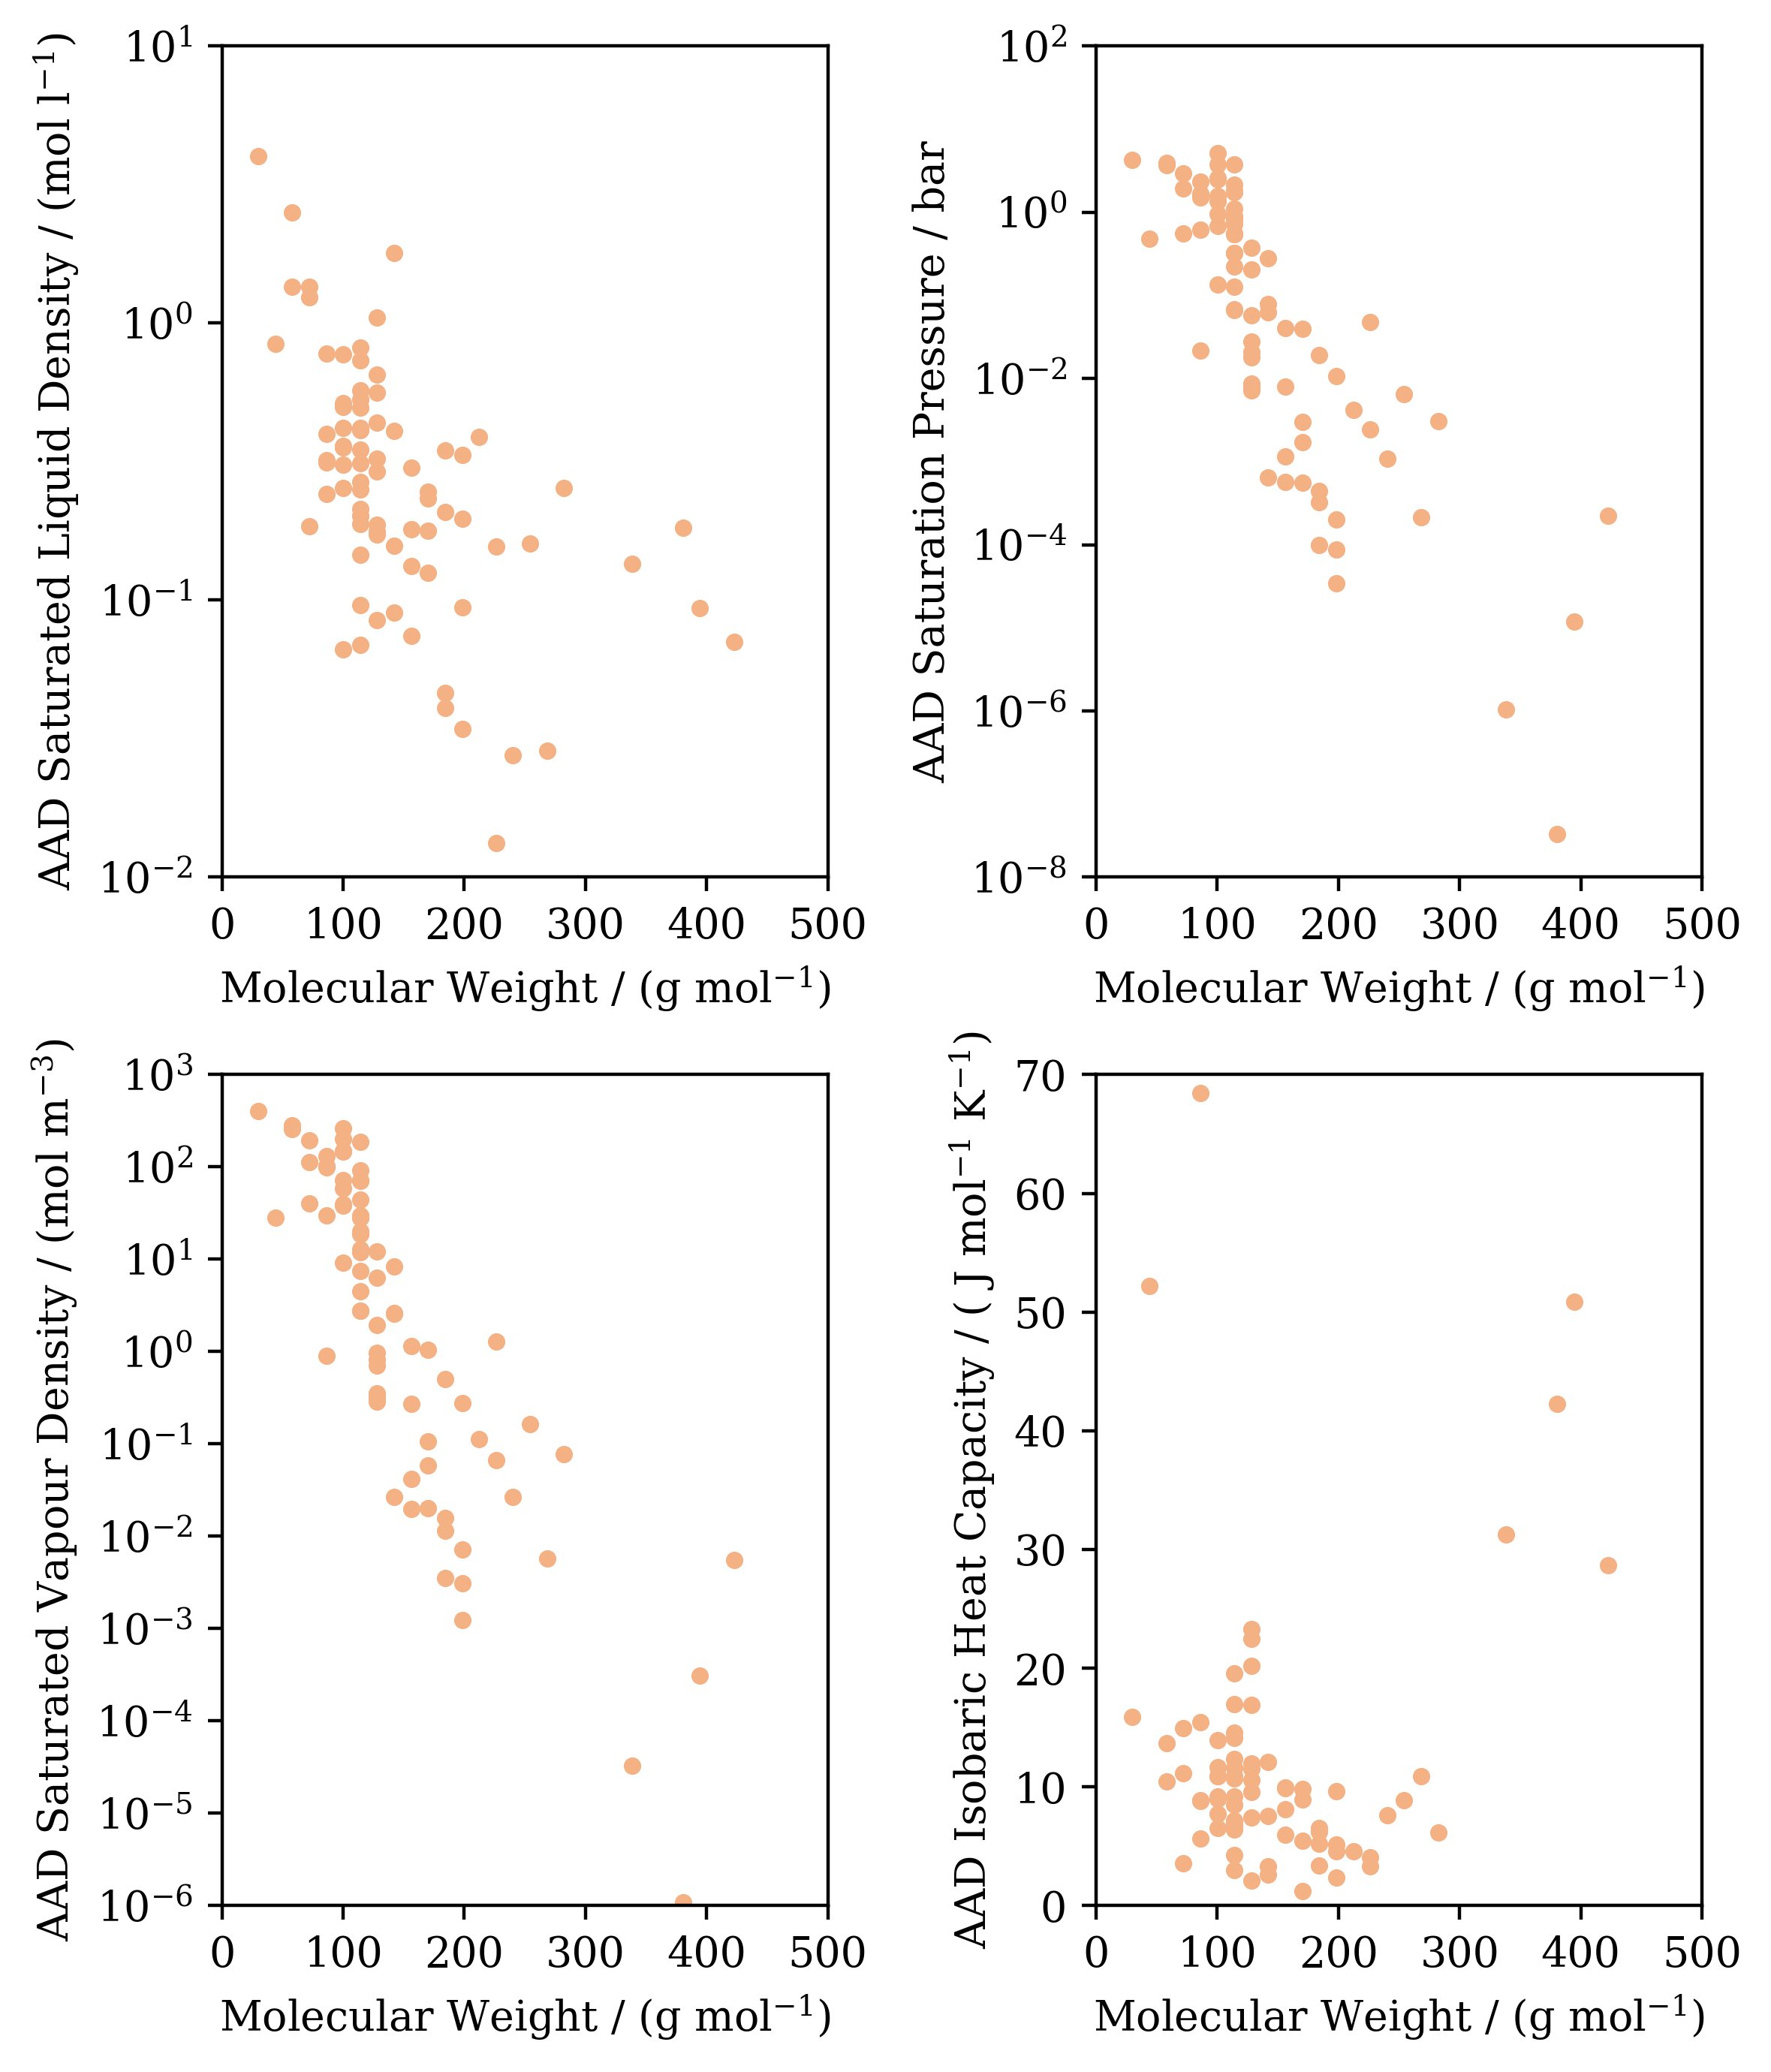

In [82]:
figure_1, axes_1 = plt.subplots(2,2, figsize=(6, 7), dpi=400)

size_points = 10
colour = "#F4B183"

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif",size=10)

axes_1[1].scatter(val_data_summary_AAD.Mw, val_data_summary_AAD.AAD_rhosat_l ./10^3,s=size_points,color=colour)
axes_1[2].scatter(val_data_summary_AAD.Mw, val_data_summary_AAD.AAD_rhosat_v,s=size_points,color=colour)
axes_1[3].scatter(val_data_summary_AAD.Mw, val_data_summary_AAD.AAD_psat ./10^5,s=size_points,color=colour)
axes_1[4].scatter(val_data_summary_AAD.Mw, val_data_summary_AAD.AAD_cp,s=size_points,color=colour)

# axes_1[1].set_ylabel(L"APD Saturated Liquid Density / (mol L$\mathregular{^{-1}}$)")
axes_1[1].set_ylabel(L"AAD Saturated Liquid Density / (mol l$\mathregular{^{-1}}$)")
axes_1[1].set_xlabel(L"Molecular Weight / (g mol$\mathregular{^{-1}}$)")
axes_1[1].set_xticks([0, 100, 200, 300, 400, 500])
axes_1[1].set_xlim([0, 500])
axes_1[1].set_ylim([10^-2, 10^1])
axes_1[1].set_yscale("log")
axes_1[1].minorticks_off()

# axes_1[2].set_ylabel(L"APD Saturated Vapour Density / (mol L$\mathregular{^{-1}}$)")
axes_1[2].set_ylabel(L"AAD Saturated Vapour Density / (mol m$\mathregular{^{-3}}$)")
axes_1[2].set_xlabel(L"Molecular Weight / (g mol$\mathregular{^{-1}}$)")
axes_1[2].set_xticks([0, 100, 200, 300, 400, 500])
axes_1[2].set_xlim([0, 500])
axes_1[2].set_ylim([10^-6, 10^3])
axes_1[2].set_yscale("log")
axes_1[2].minorticks_off()

# axes_1[3].set_ylabel("APD Saturation Pressure / Pa")
axes_1[3].set_ylabel("AAD Saturation Pressure / bar")
axes_1[3].set_xlabel(L"Molecular Weight / (g mol$\mathregular{^{-1}}$)")
axes_1[3].set_xticks([0, 100, 200, 300, 400, 500])
axes_1[3].set_xlim([0, 500])
axes_1[3].set_ylim([10^-8, 10^2])
axes_1[3].set_yscale("log")

# axes_1[4].set_ylabel(L"APD Isobaric Heat Capacity / ( J mol$\mathregular{^{-1}}$ K$\mathregular{^{-1}}$)")
axes_1[4].set_ylabel(L"AAD Isobaric Heat Capacity / ( J mol$\mathregular{^{-1}}$ K$\mathregular{^{-1}}$)")
axes_1[4].set_xlabel(L"Molecular Weight / (g mol$\mathregular{^{-1}}$)")
axes_1[4].set_xticks([0, 100, 200, 300, 400, 500])
axes_1[4].set_xlim([0, 500])
axes_1[4].set_ylim([0, 70])

figure_1.tight_layout()
# plt.savefig("AADs with Mw.svg")


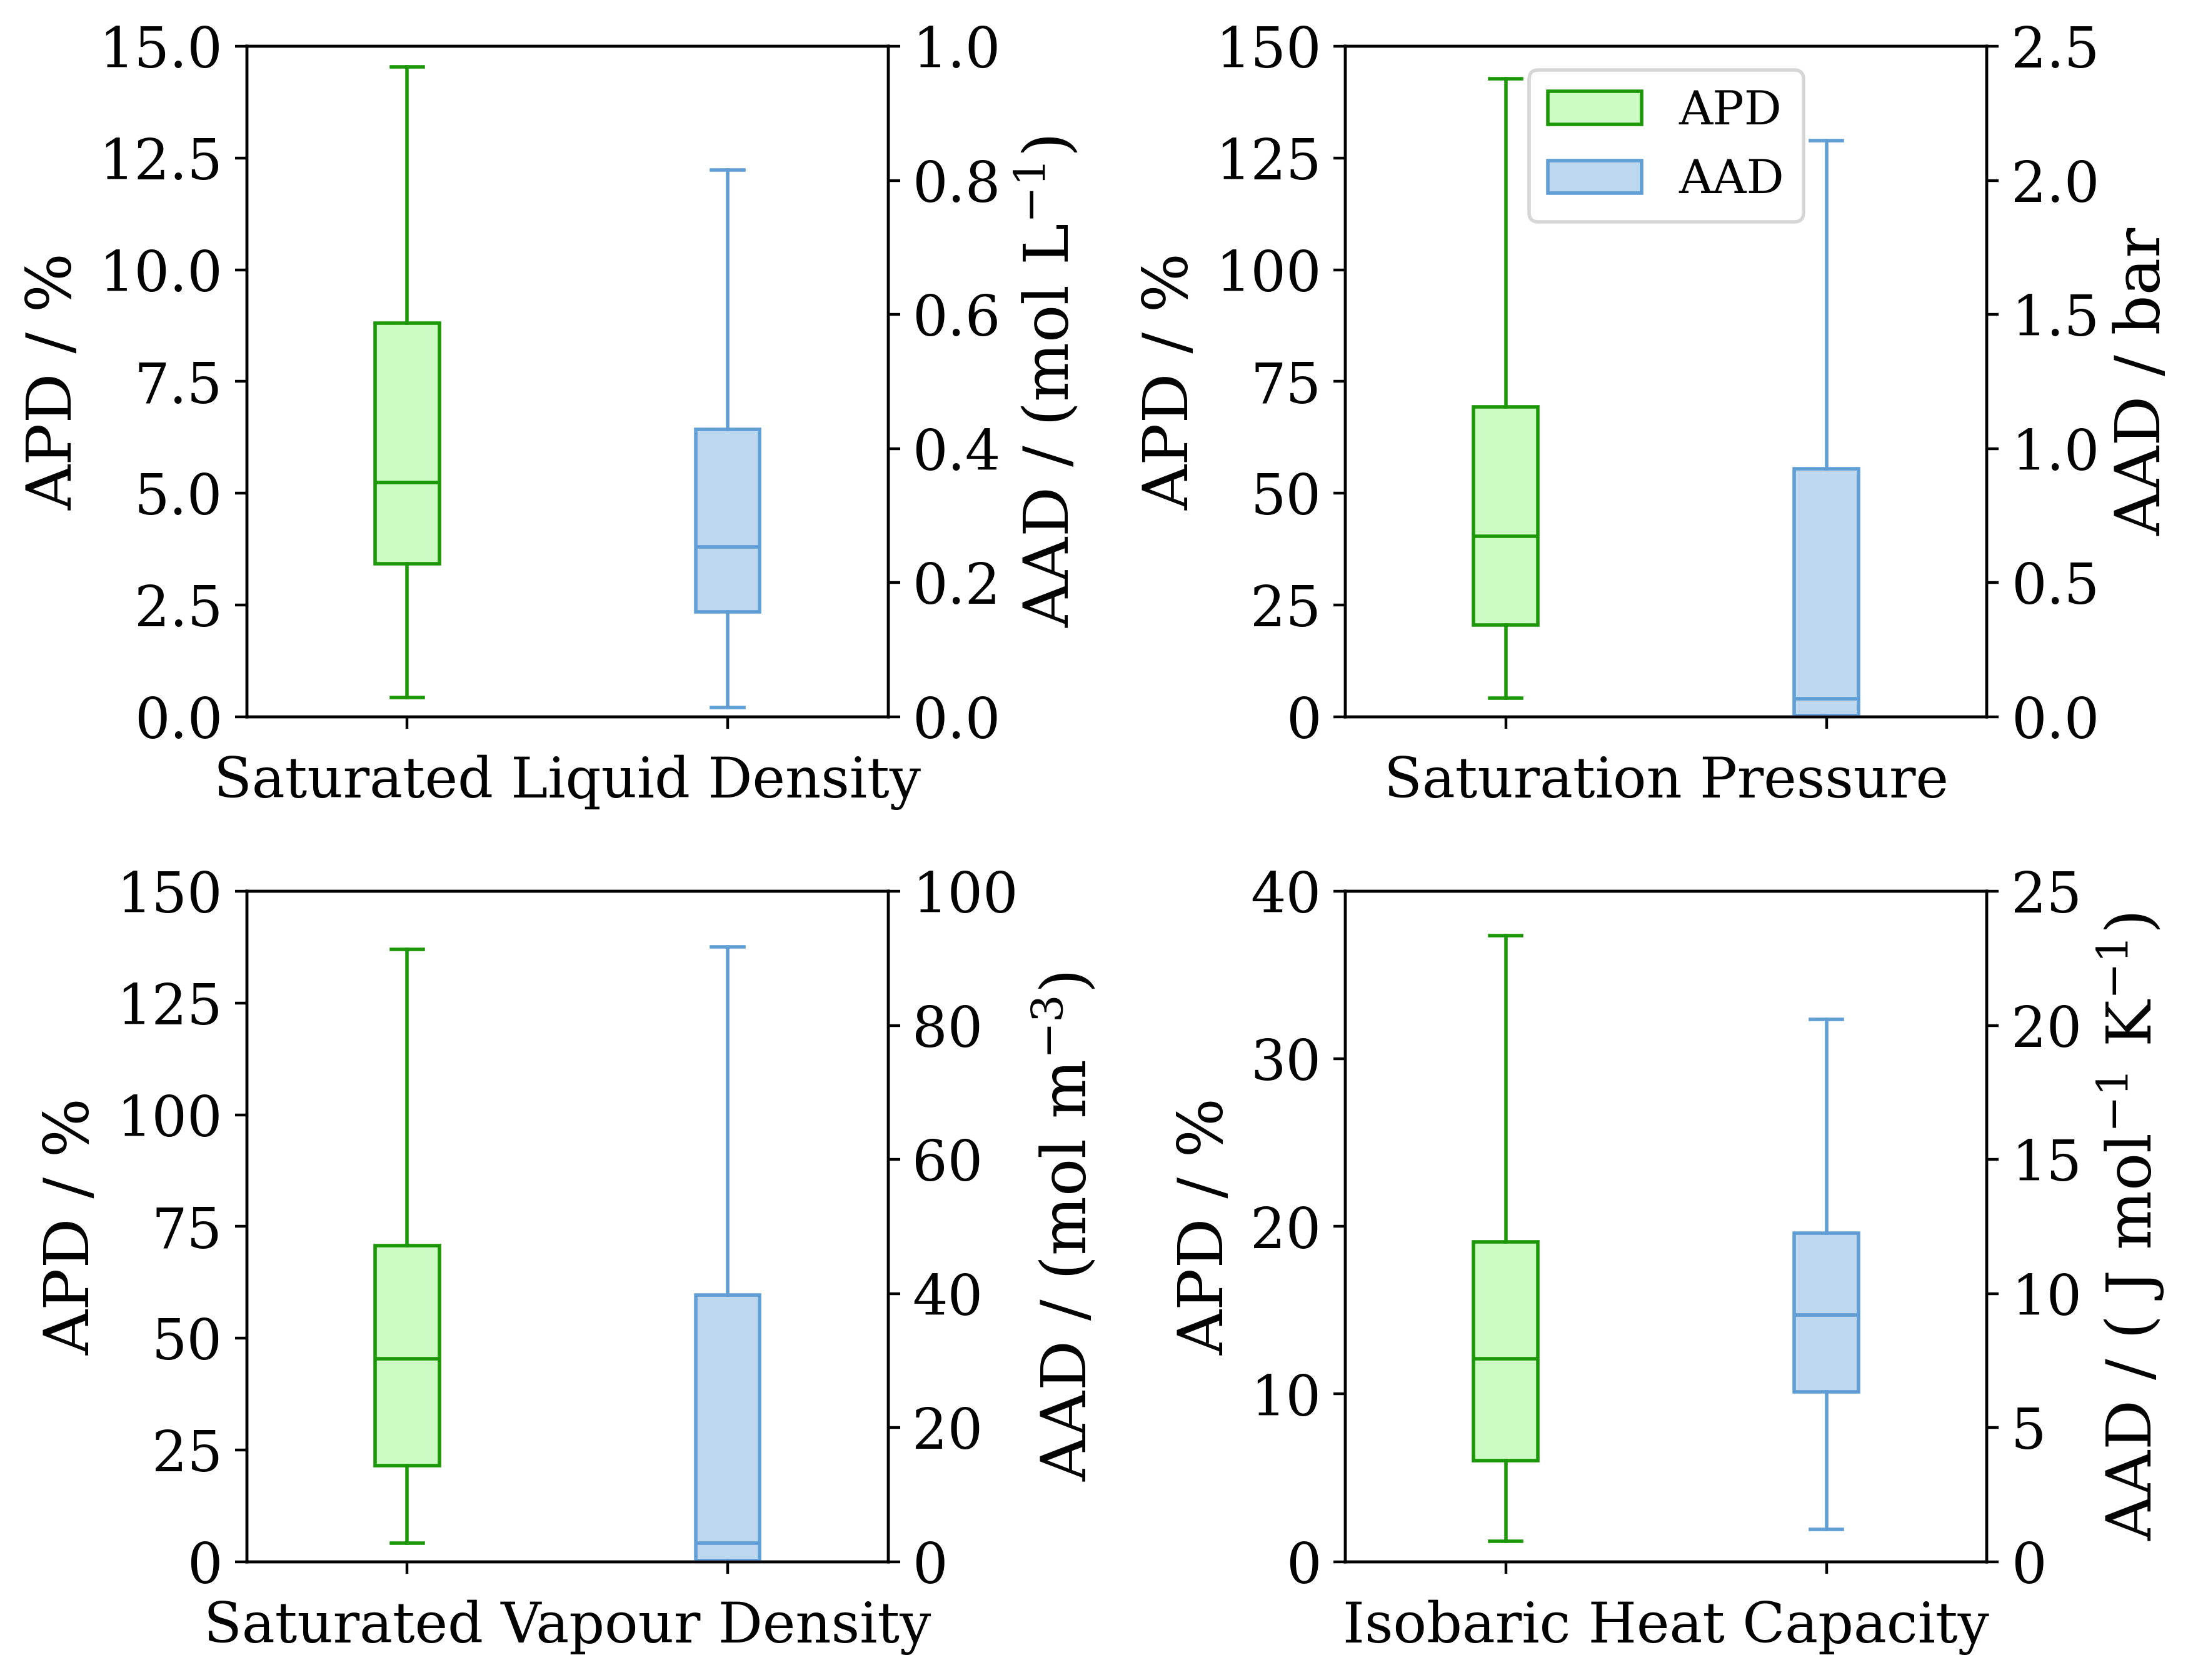

In [36]:
matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif",size=16)

figure_2, axes_2 = plt.subplots(2,2, figsize=(9, 7), dpi=400)

# Green box properties
boxprops1 = Dict("linewidth" => 1, "color" => "#1C9707", "facecolor" => "#CCFCC4")  # Add facecolor for box fill
whiskerprops1 = Dict("linewidth" => 1, "color" => "#1C9707")
capprops1 = Dict("linewidth" => 1, "color" => "#1C9707")
flierprops1 = Dict("markerfacecolor" => "#CCFCC4", "marker" => "o", "markersize" => 8, "linestyle" => "none","markeredgecolor" => "#1C9707")
medianprops1 = Dict("color" => "#1C9707")

# Blue box properties
boxprops2 = Dict("linewidth" => 1, "color" => "#609ED6", "facecolor" => "#BDD7EE")  # Add facecolor for box fill
whiskerprops2 = Dict("linewidth" => 1, "color" => "#609ED6")
capprops2 = Dict("linewidth" => 1, "color" => "#609ED6")
flierprops2 = Dict("markerfacecolor" => "#609ED6", "marker" => "o", "markersize" => 8, "linestyle" => "none","markeredgecolor" => "#1C9707")
medianprops2 = Dict("color" => "#609ED6")

box_width = 0.2
showfliers = false

y_lims_AAD = [1.0, 100, 2.5, 25]
y_lims_APD = [15, 150, 150, 40]

cols_AAD = [:AAD_rhosat_l, :AAD_rhosat_v, :AAD_psat, :AAD_cp]
cols_APD = [:APD_rhosat_l, :APD_rhosat_v, :APD_psat, :APD_cp]
properties = ["Saturated Liquid Density","Saturated Vapour Density","Saturation Pressure","Isobaric Heat Capacity"]
units = [L"(mol L$\mathregular{^{-1}}$)",L"(mol m$\mathregular{^{-3}}$)","bar", L"( J mol$\mathregular{^{-1}}$ K$\mathregular{^{-1}}$)"]

for (p, q, i) in zip(cols_AAD, cols_APD, 1:length(cols_AAD))

    abs_dev = val_data_summary_AAD[:, cols_AAD[i]]

    if i == 1
        abs_dev = val_data_summary_AAD[:, cols_AAD[i]] ./10^3
    end

    if i == 3
        abs_dev = val_data_summary_AAD[:, cols_AAD[i]] ./10^5
    end
    
    bp1 = axes_2[i].boxplot(val_data_summary_APD[:, cols_APD[i]], positions=[1], boxprops=boxprops1, whiskerprops=whiskerprops1, capprops=capprops1, flierprops=flierprops1, medianprops=medianprops1, patch_artist=true, widths=box_width,showfliers=showfliers)
    axes_2[i].set_ylabel("APD / %",fontsize=18)
    axes_2[i].set_xticklabels("")
    axes_2[i].set_ylim([0, y_lims_APD[i]])
    axes_2[i].set_xlabel(properties[i])

    axes_2_1_2 = axes_2[i].twinx()
    bp2 = axes_2_1_2.boxplot(abs_dev, positions=[2], boxprops=boxprops2, whiskerprops=whiskerprops2, capprops=capprops2, flierprops=flierprops2, medianprops=medianprops2, patch_artist=true, widths=box_width,showfliers=showfliers)
    axes_2_1_2.set_ylabel("AAD / $(units[i])",fontsize=18)
    axes_2_1_2.set_xticklabels("")
    axes_2_1_2.set_ylim([0, y_lims_AAD[i]])

    if i == 3
        axes_2[i].legend([bp1["boxes"][1], bp2["boxes"][1]], ["APD", "AAD"], loc="upper center",fontsize=13.5)
    end   

end

figure_2.tight_layout()

# plt.savefig("AADs and APDs.svg")

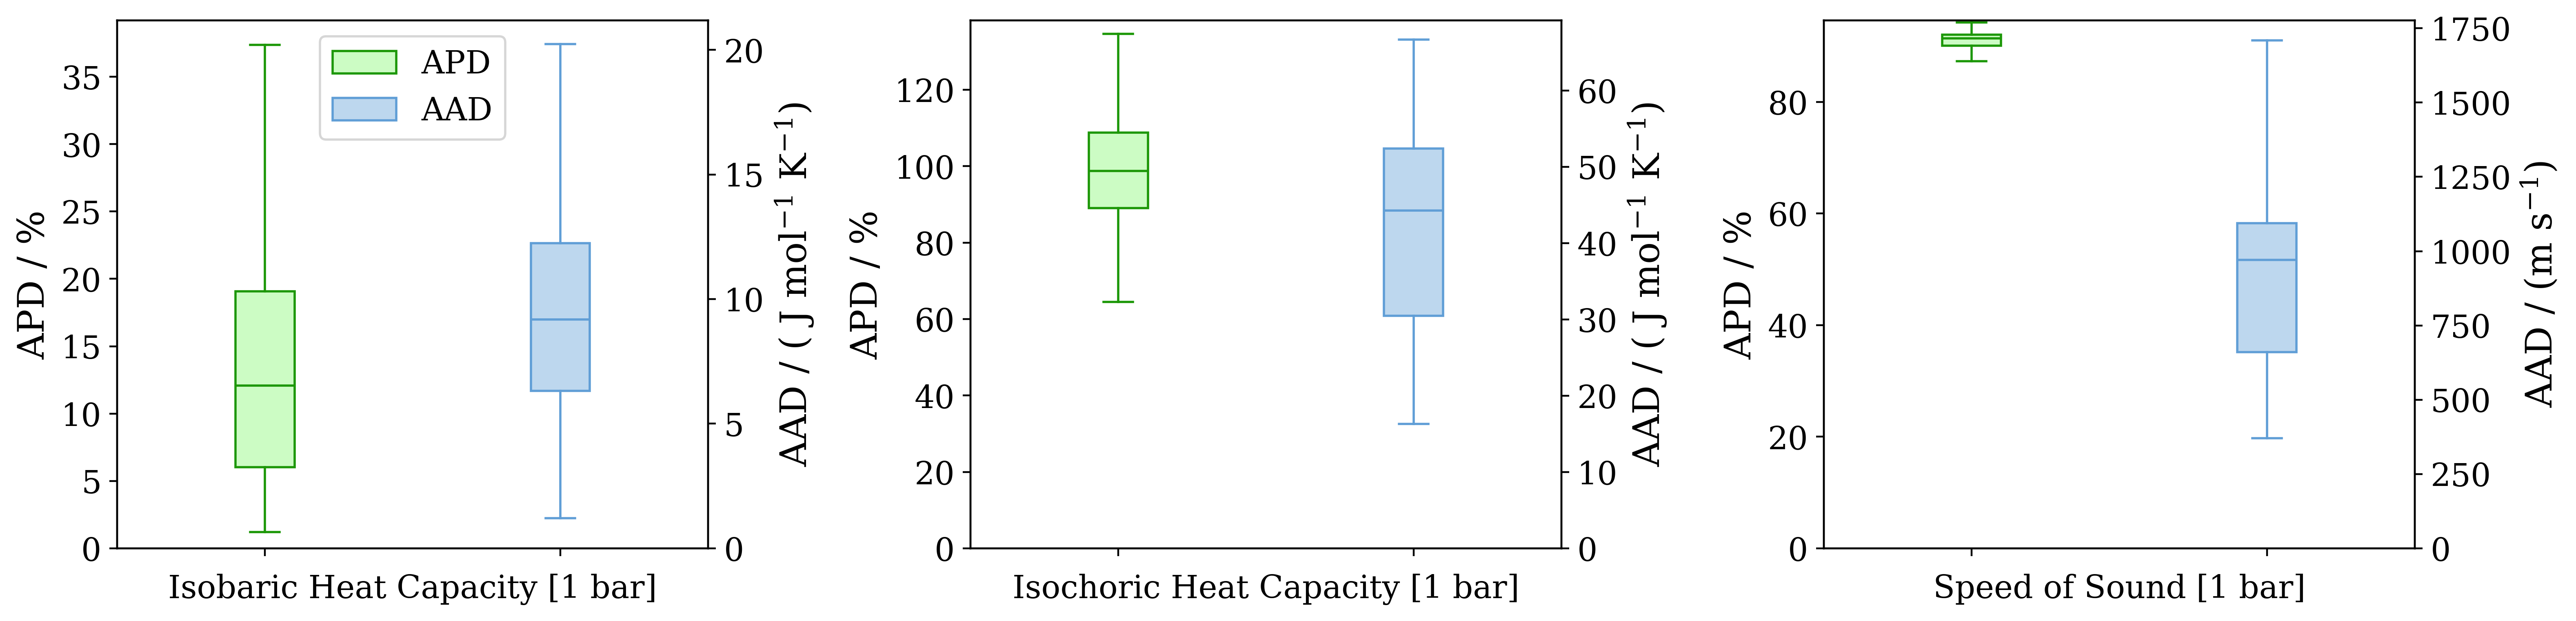

In [106]:
subplot_rows = 1
subplot_cols = 3

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif",size=14)

figure_2, axes_2 = plt.subplots(subplot_rows,subplot_cols, figsize=(16, 4), dpi=400)

# Green box properties
boxprops1 = Dict("linewidth" => 1, "color" => "#1C9707", "facecolor" => "#CCFCC4")  # Add facecolor for box fill
whiskerprops1 = Dict("linewidth" => 1, "color" => "#1C9707")
capprops1 = Dict("linewidth" => 1, "color" => "#1C9707")
flierprops1 = Dict("markerfacecolor" => "#CCFCC4", "marker" => "o", "markersize" => 8, "linestyle" => "none","markeredgecolor" => "#1C9707")
medianprops1 = Dict("color" => "#1C9707")

# Blue box properties
boxprops2 = Dict("linewidth" => 1, "color" => "#609ED6", "facecolor" => "#BDD7EE")  # Add facecolor for box fill
whiskerprops2 = Dict("linewidth" => 1, "color" => "#609ED6")
capprops2 = Dict("linewidth" => 1, "color" => "#609ED6")
flierprops2 = Dict("markerfacecolor" => "#609ED6", "marker" => "o", "markersize" => 8, "linestyle" => "none","markeredgecolor" => "#1C9707")
medianprops2 = Dict("color" => "#609ED6")

box_width = 0.2
showfliers = false

cols_AAD = [:AAD_cp, :AAD_cv, :AAD_speed_sound]
cols_APD = [:APD_cp, :APD_cv, :APD_speed_sound]
properties = ["Isobaric Heat Capacity [1 bar]", "Isochoric Heat Capacity [1 bar]", "Speed of Sound [1 bar]"]
units = [L"( J mol$\mathregular{^{-1}}$ K$\mathregular{^{-1}}$)", L"( J mol$\mathregular{^{-1}}$ K$\mathregular{^{-1}}$)", L"(m s$\mathregular{^{-1}}$)"]

for (p, q, i) in zip(cols_AAD, cols_APD, 1:length(cols_AAD))

    abs_dev = val_data_summary_AAD[:, cols_AAD[i]]
    
    bp1 = axes_2[i].boxplot(val_data_summary_APD[:, cols_APD[i]], positions=[1], boxprops=boxprops1, whiskerprops=whiskerprops1, capprops=capprops1, flierprops=flierprops1, medianprops=medianprops1, patch_artist=true, widths=box_width,showfliers=showfliers)
    axes_2[i].set_ylabel("APD / %",fontsize=16)
    axes_2[i].set_xticklabels("")
    axes_2[i].set_ylim([0, nothing])
    axes_2[i].set_xlabel(properties[i])

    axes_2_1_2 = axes_2[i].twinx()
    bp2 = axes_2_1_2.boxplot(abs_dev, positions=[2], boxprops=boxprops2, whiskerprops=whiskerprops2, capprops=capprops2, flierprops=flierprops2, medianprops=medianprops2, patch_artist=true, widths=box_width,showfliers=showfliers)
    axes_2_1_2.set_ylabel("AAD / $(units[i])",fontsize=16)
    axes_2_1_2.set_xticklabels("")
    axes_2_1_2.set_ylim([0, nothing])

    if i == 1
        axes_2[i].legend([bp1["boxes"][1], bp2["boxes"][1]], ["APD", "AAD"], loc="upper center")
    end   

end

figure_2.tight_layout()

In [15]:
contains_only_c(name) = all(letter -> lowercase(letter) == 'c', name);
processed_data_lin_alkanes = [filter(row -> contains_only_c(row.isomeric_SMILES), i) for i in processed_data_storage]
processed_data_lin_alkanes = sort.(processed_data_lin_alkanes, :Mw);

0.9434812052021184
0.9735646915549946
0.8658211275644316


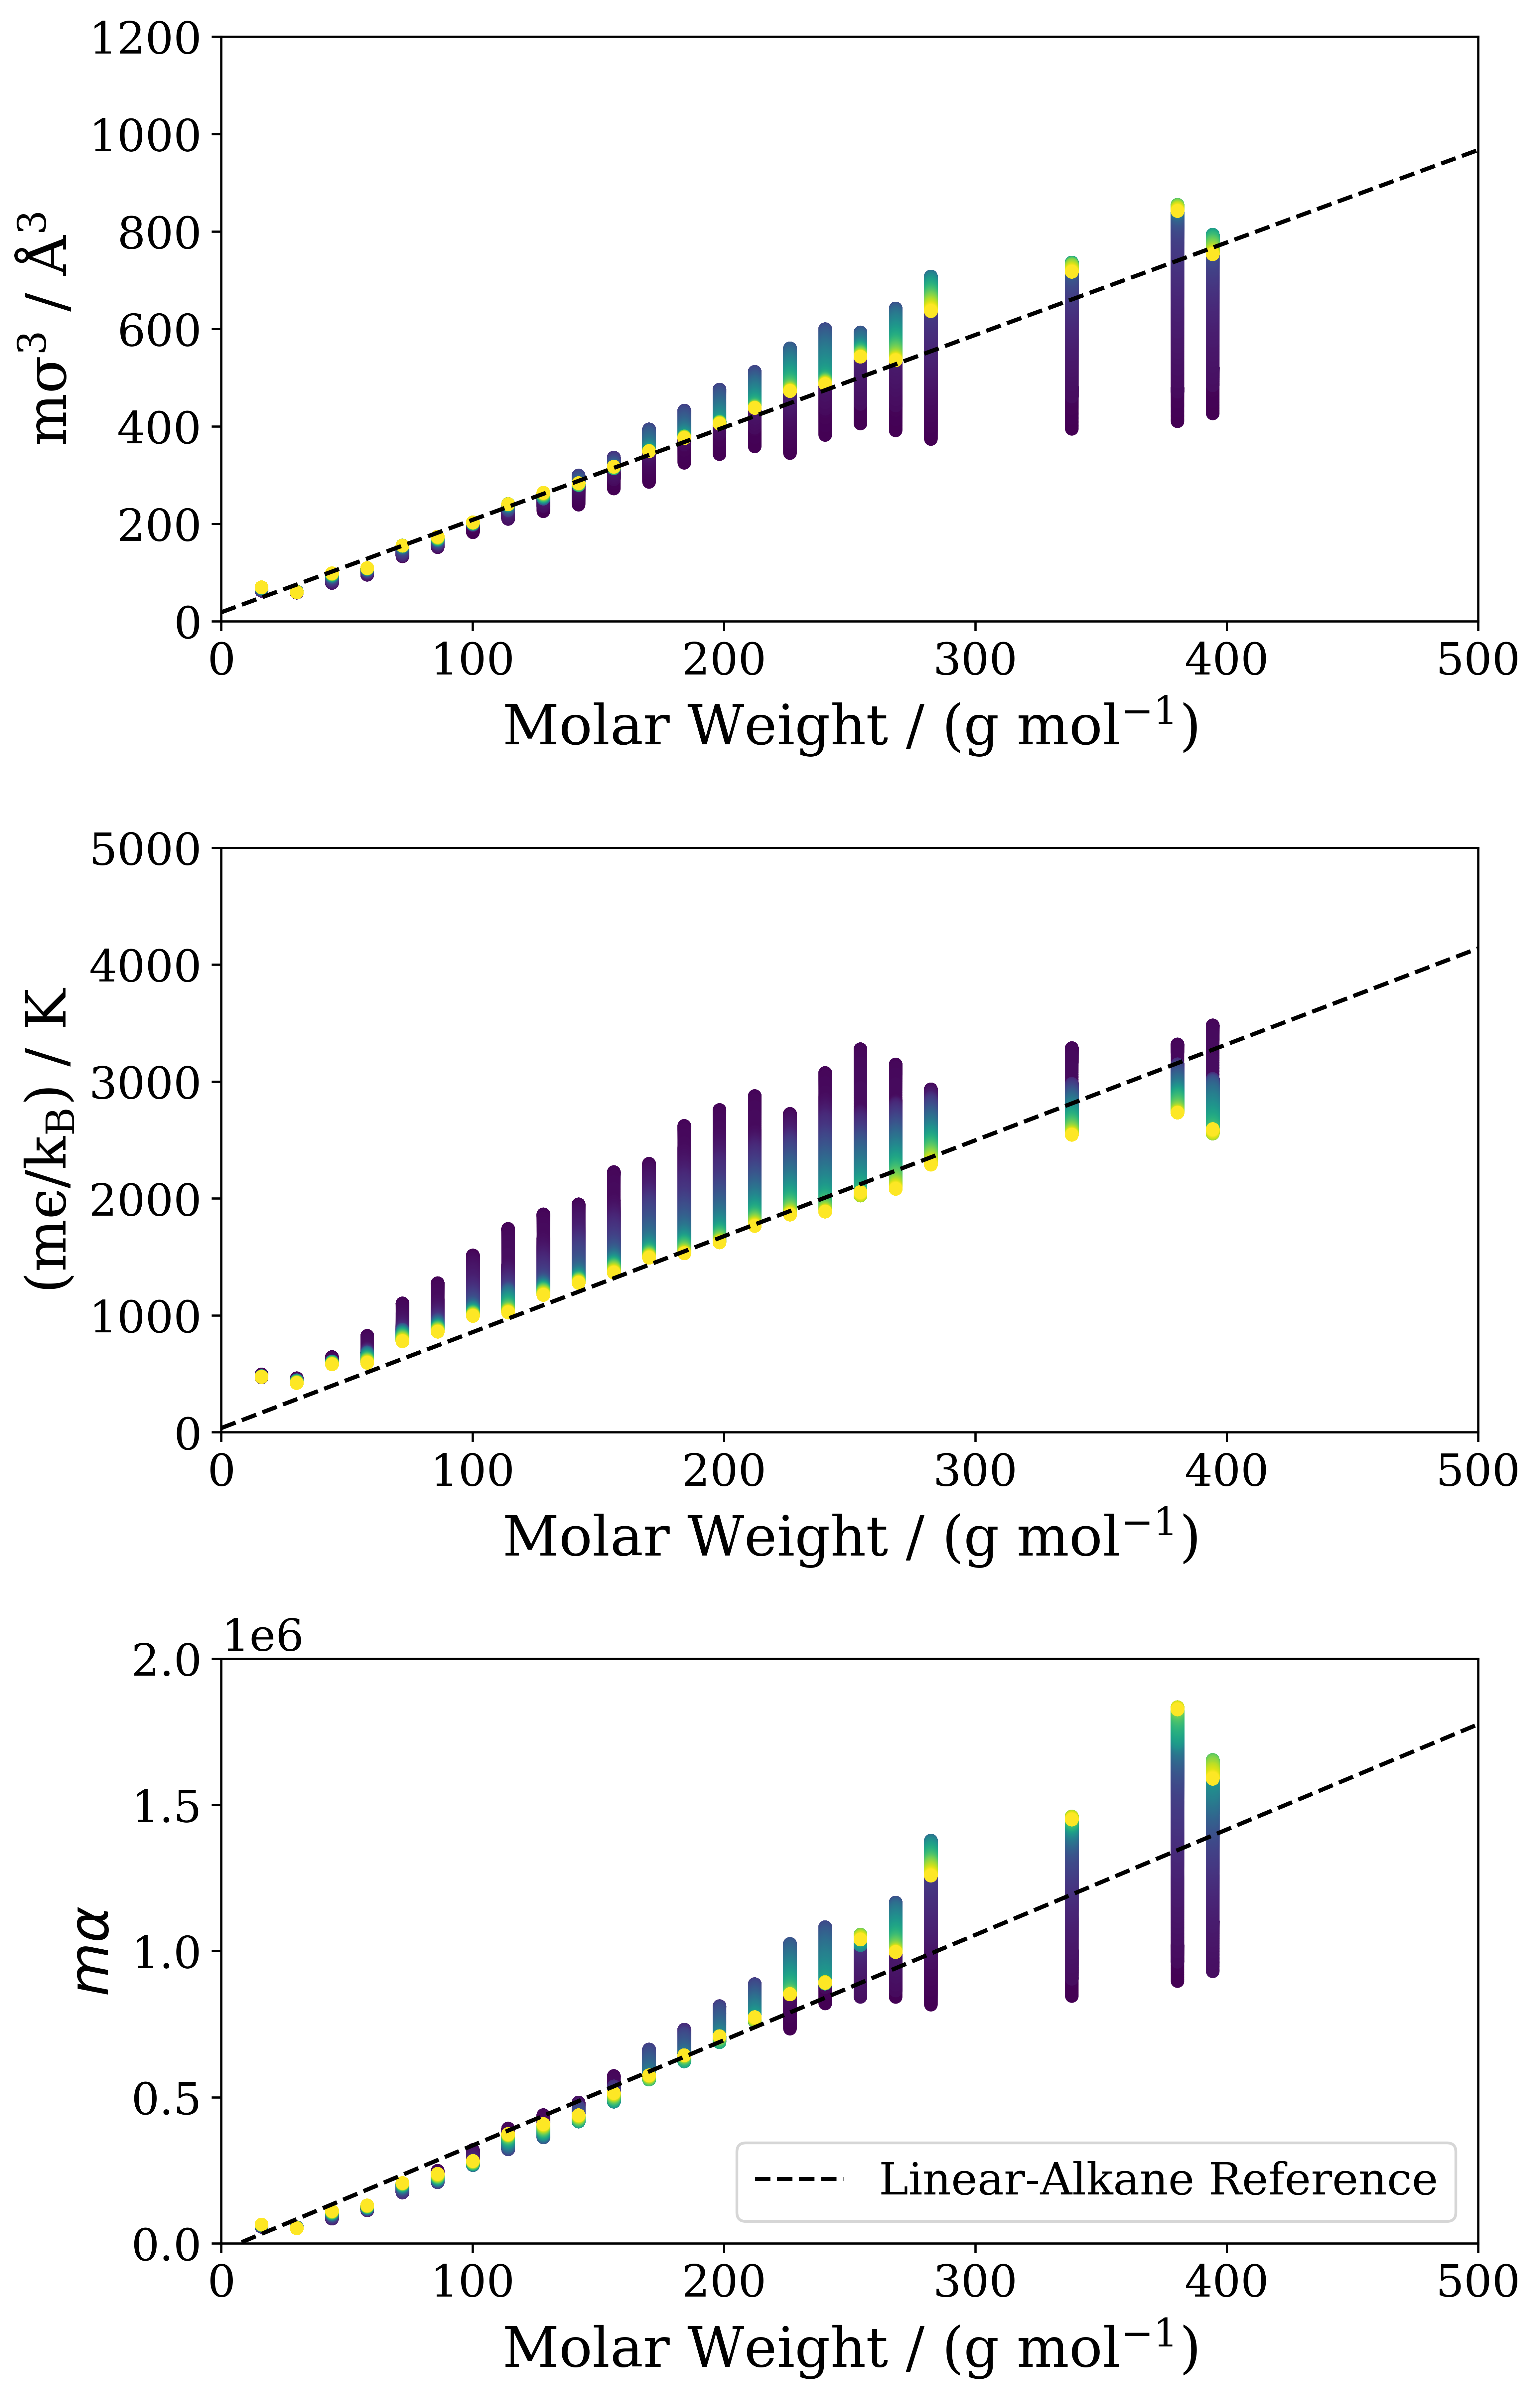

In [18]:
epoch = 2005 #minimum(total_epochs) #(shortest of all five folds), true (max length each fold)

analyse_training == false
vmin = 1
vmax = epoch

colour_bar_interval = 10
colour_scheme = "viridis"
scatter_plot_size = 15
label_fontsize = 20

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif", size=16)

species_list = string.(vcat(collect(processed_data_lin_alkanes[i][!,:species] for i = 1:length(files_to_average))...))

figure_1, axes_1 = plt.subplots(4, 1, figsize=(8, 16), dpi=600)
color_mapping = collect(range(vmin, vmax))
ideal_Mw = collect(range(0, 500, epoch))

ideal_mσ3s = [1.8975 * i + 18.278 for i in ideal_Mw]
ideal_mϵs = [8.2034 * i + 36.245 for i in ideal_Mw]
ideal_mvdwas = [3601.359 * i + -25018.327 for i in ideal_Mw]

axes_1[1].plot(ideal_Mw, ideal_mσ3s, color="k", "--")
axes_1[2].plot(ideal_Mw, ideal_mϵs, color="k", "--")
axes_1[3].plot(ideal_Mw, ideal_mvdwas, color="k", "--")

Mw = []; mϵ = []; mϵs = []; mσ3s = []; Mws = []; mvdw_as = [];

for i = 1:length(species_list)

    if analyse_training == true
        processed_data_split = processed_data_lin_alkanes[Int(floor((i-1)/64) + 1)]
    else
    # find species i data
    key_i = find_key(string_arrays_dict, lowercase(species_list[i]))
    processed_data_split = processed_data_lin_alkanes[key_i]
    end

    processed_data_split = filter(row -> row.species == species_list[i], processed_data_split)

    if epoch == true
        epoch = length(processed_data_lin_alkanes[j][1,:m])
    end
    
    Mw = fill(processed_data_split[1,:Mw], epoch)
    ms = processed_data_split[1,:m]
    σs = processed_data_split[1,:σ]
    ϵs = processed_data_split[1,:ϵ]
    λ_rs = processed_data_split[1,:λ_r]
    λ_as = 6

    mσ3 = [ms[i] * σs[i]^3 for i in 1:epoch]
    mϵ = [ms[i]^1 * ϵs[i] for i in 1:epoch]

    mvdw_a = [-2*pi * ((λ_rs[i]/(λ_rs[i] - λ_as))*(λ_rs[i]/λ_as)^(λ_as/(λ_rs[i]-λ_as))) * (ϵs[i] * σs[i]^3 * ms[i]^1 * (1/(λ_rs[i] - 3) - 1/(λ_as-3))) for i in 1:epoch]

    axes_1[3].scatter(Mw, mvdw_a, c=color_mapping, cmap=colour_scheme,s=scatter_plot_size,vmin=vmin,vmax=vmax)
    axes_1[2].scatter(Mw, mϵ, c=color_mapping, cmap=colour_scheme,s=scatter_plot_size,vmin=vmin,vmax=vmax)
    axes_1[1].scatter(Mw, mσ3, c=color_mapping, cmap=colour_scheme,s=scatter_plot_size,vmin=vmin,vmax=vmax)

    push!(mσ3s, mσ3)
    push!(mϵs, mϵ)
    push!(mvdw_as, mvdw_a)
    push!(Mws, processed_data_split[1,:Mw])

end

# Plot 1 details
axes_1[1].set_xlabel(L"Molar Weight / (g mol$\mathregular{^{-1}}$)", fontsize=label_fontsize)
axes_1[1].set_ylabel(L"mσ$\mathregular{^3}$ / Å$\mathregular{^3}$", fontsize=label_fontsize)
axes_1[1].set_ylim([0, 1200])
axes_1[1].set_xlim([0, 500])

# axes_1[1].legend(["Lafitte et al. (2013), Hosseinifar et al. (2016)"], loc="upper left", fontsize=16)
axes_1[2].set_xlabel(L"Molar Weight / (g mol$\mathregular{^{-1}}$)", fontsize=label_fontsize)
axes_1[2].set_ylabel(L"(mϵ/k$\mathregular{_B}$) / K", fontsize=label_fontsize)
axes_1[2].set_ylim([0, 5000])
axes_1[2].set_xlim([0, 500])

axes_1[3].set_xlabel(L"Molar Weight / (g mol$\mathregular{^{-1}}$)", fontsize=label_fontsize)
axes_1[3].set_ylabel(L"m\alpha", fontsize=label_fontsize)
axes_1[3].set_ylim([0, 2e6])
axes_1[3].set_xlim([0, 500])
axes_1[3].legend(["Linear-Alkane Reference"], loc="lower right", fontsize=16)


figure_1.tight_layout()

# cax = figure_1.add_axes([0.61, 0.05, 0.07, 1])
# cbar = figure_1.colorbar(axes_1[2].scatter(Mw, mϵ, c=color_mapping, cmap=colour_scheme,s=scatter_plot_size), ax=cax, ticks=vmin:colour_bar_interval:vmax, label="Training Progress / %")
# plt.delaxes(cax)
plt.delaxes(axes_1[4])

# Restructure mϵ and mσ3 (from 23 vectors of length epoch to epoch vectors of length 23)
mϵs_restruc = [[mϵs[j][i] for j = 1:length(species_list)] for i = 1:epoch]
mσ3_restruc = [[mσ3s[j][i] for j = 1:length(species_list)] for i = 1:epoch]
mvdwa_restruc = [[mvdw_as[j][i] for j = 1:length(species_list)] for i = 1:epoch]

# Obtain reference mϵ and mσ3 at the given Mws
mϵ_pred_r2 = [8.2034 * i + 36.245 for i in Mws]
mσ3_pred_r2 = [1.8975 * i + 18.278 for i in Mws]
mvdwa_pred_r2 = [3601.359 * i - 25018.327 for i in Mws]

# Compute r2 values
r2mϵ = [r_squared(y_actual = mϵ_pred_r2, y_predicted = mϵs_restruc[i]) for i = 1:epoch]
r2mσ3 = [r_squared(y_actual = mσ3_pred_r2, y_predicted = mσ3_restruc[i]) for i = 1:epoch]#
r2mvdwa = [r_squared(y_actual = mvdwa_pred_r2, y_predicted = mvdwa_restruc[i]) for i = 1:epoch]#

# To save the figure
# plt.savefig("all_compound_phase_envelopes.png", dpi=400)

println(r2mϵ[end])
println(r2mσ3[end])
println(r2mvdwa[end])
# println(ideal_mϵs_restruc)